In [1]:
#!conda env list

## 1 Set API Key and create JD Dataframe

In [10]:
import os
from openai import OpenAI 

## Set the API key and model name
MODEL="gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")
client = OpenAI(api_key=api_key)

### 1.1 Try out functionality

In [11]:
completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "user", "content": "You are a helpful recruiting assistant. We have a list of candidates we want to interview for a job and we want to tailor interview questions to their skills."}, # <-- This is the system message that provides context to the model
    {"role": "system", "content": f"Hello! Based on the following candidates:, could you make a list of 5 interview questions for all of them based on their total pool of skills and how it relates to the skills required of the job - here:  "}  # <-- This is the user message for which the model will generate a response
  ]
)

In [3]:
from IPython.display import display, Markdown, Latex
display(Markdown(completion.choices[0].message.content))

Of course! However, you'll need to provide me with the candidates' names and their respective skills, as well as the job title and required skills for the position. Once I have that information, I can create tailored interview questions for each candidate.

### 1.2 Create Dataframe with Job Descriptions

In [4]:
ls

LICENSE                      main.py
LLM.ipynb                    model_improvements.ipynb
README.md                    resumes/
Resources/                   services/
__pycache__/                 source/
agenda.md                    synthetic_data.ipynb
comparison.ipynb             synthetic_data_binary.ipynb
environment.yml              user_interface/
environment_mac.yml          word_embeddings.ipynb
job_descriptions/


In [3]:
import os
import pandas as pd

job_descriptions_path = 'job_descriptions/'
files = [f for f in os.listdir(job_descriptions_path) if f.endswith('.txt')]
jobs = []

for i, filename in enumerate(files):
    with open(os.path.join(job_descriptions_path, filename), 'r', encoding='utf-8') as f:
        content = f.read().strip()
        
        # If the Job Title is the first line of the file
        lines = content.split('\n')
        job_title = lines[0]  # Assuming the first line is the Job Title
        jd = '\n'.join(lines[1:])  # The rest is the Job Description
        
        # If the Job Title is derived from the filename instead, uncomment the next line
        # job_title = os.path.splitext(filename)[0]  # Filename without extension
        
        jobs.append({
            'Job ID': i + 1,
            'Job Title': job_title,
            'JD': jd
        })

df_jobs = pd.DataFrame(jobs)
df_jobs

,Job ID,Job Title,JD
0,1,,
1,2,,
2,3,,
3,4,,
4,5,,
5,6,"Machine Learning Engineer, Sage, London",\nFull job description\n\nAbout our Team:\nThe...
6,7,,
7,8,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
8,9,Data Scientist,Lisbon\n\n\n\nApply on employer site\n\n\nAppl...
9,10,Junior Data Engineer,"At Capgemini Engineering, the world leader in ..."


In [4]:
job_titles_to_keep = [
    'Senior Data Scientist, WTW, London',
    'Software Engineer II, Android, Microsoft, London'
]

df_filtered = df_jobs[df_jobs['Job Title'].isin(job_titles_to_keep)].reset_index(drop=True)
df_filtered['Job ID'] = df_filtered.index + 1
df_filtered

,Job ID,Job Title,JD
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
1,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...


## 2 Binary

### New Approach for Creating Synthetic Data with Clear Skill Match Separation

#### Goal
The goal is to create a synthetic dataset that generates three resumes per job description (JD) with a perfect to very good fit to the skills mentioned in the JD. Additionally, in a separate API call, three resumes will be generated for each job description that have a poor skill match to the JD.

#### Approach

1. **Creating Resumes with Good Fit:**
    - For each job description, three resumes will be generated.
    - These resumes should have a perfect to very good fit to the skills mentioned in the JD.
    - These resumes will be created in the first API call.

2. **Creating Resumes with Poor Fit:**
    - For each job description, three additional resumes will be generated.
    - These resumes should have a poor skill match to the JD, meaning they contain irrelevant skills that do not align or relate to the skills mentioned in the JD.
    - These resumes will be created in a second, separate API call.

#### Next Steps
In the next step, we will create the code to implement this approach. The code will:
- Iterate through the job descriptions.
- Generate three resumes with a good fit for each job description.
- Generate three resumes with a poor fit for each job description.
- Store and display the generated resumes in a DataFrame.

This approach aims to ensure that the generated resumes have clearly distinguishable skill matches, providing a better foundation for further analysis.

### 2.1 First Attempt - Binary Approach

**Specs:**
- 1 Promt generating 3 resumes: Ranked from 1-3 (perfect, very good, good fit)
- 1 Promt generating 3 resumes: Ranked from 4-6 (poor, very poor, no fit)

#### 2.1.1 Good fit resumes (Ranked 1-3)

In [7]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 3** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 3, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **2 = Very Good Fit** (very good alignment of skills and related skills between resume and job description).
- **3 = Good Fit** (good alignment of skills and related skills between resume and job description).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,**Resume: John Smith** \n[Email: john.smith@e...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,**Candidate Resume**\n\n**Name:** John Doe \n...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,**Candidate Name:** John Smith \n**Location:*...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Resume for Candidate: Alex Johnson**\n\n**Co...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,**Candidate Name:** Alex Johnson \n**Email:**...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,**Candidate Name:** Alice Thompson \n**Email:...,3


In [8]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_5_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.1.2 Bad fit resumes (Ranked 4-6)

In [9]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 3** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 3, where:
- **1 = Poor Fit** (poor alignment of skills and related skills between resume and job description).
- **2 = Very Poor Fit** (very poor alignment of skills and related skills between resume and job description).
- **3 = No Fit** (no alignment of skills and related skills between resume and job description - the candidate comes from another field entirely, such as marketing or finance).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Candidate Resume: John Smith**\n\n**Contact ...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,**Candidate Name:** David Thompson \n**Contac...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume for Candidate A**\n\n**Name:** John S...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Candidate Name:** Sarah Thompson \n**Locati...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume: John Smith** \n[Phone: (555) 123-45...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,**Candidate Resume: John Doe**\n\n**Contact In...,3


In [10]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_5_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)


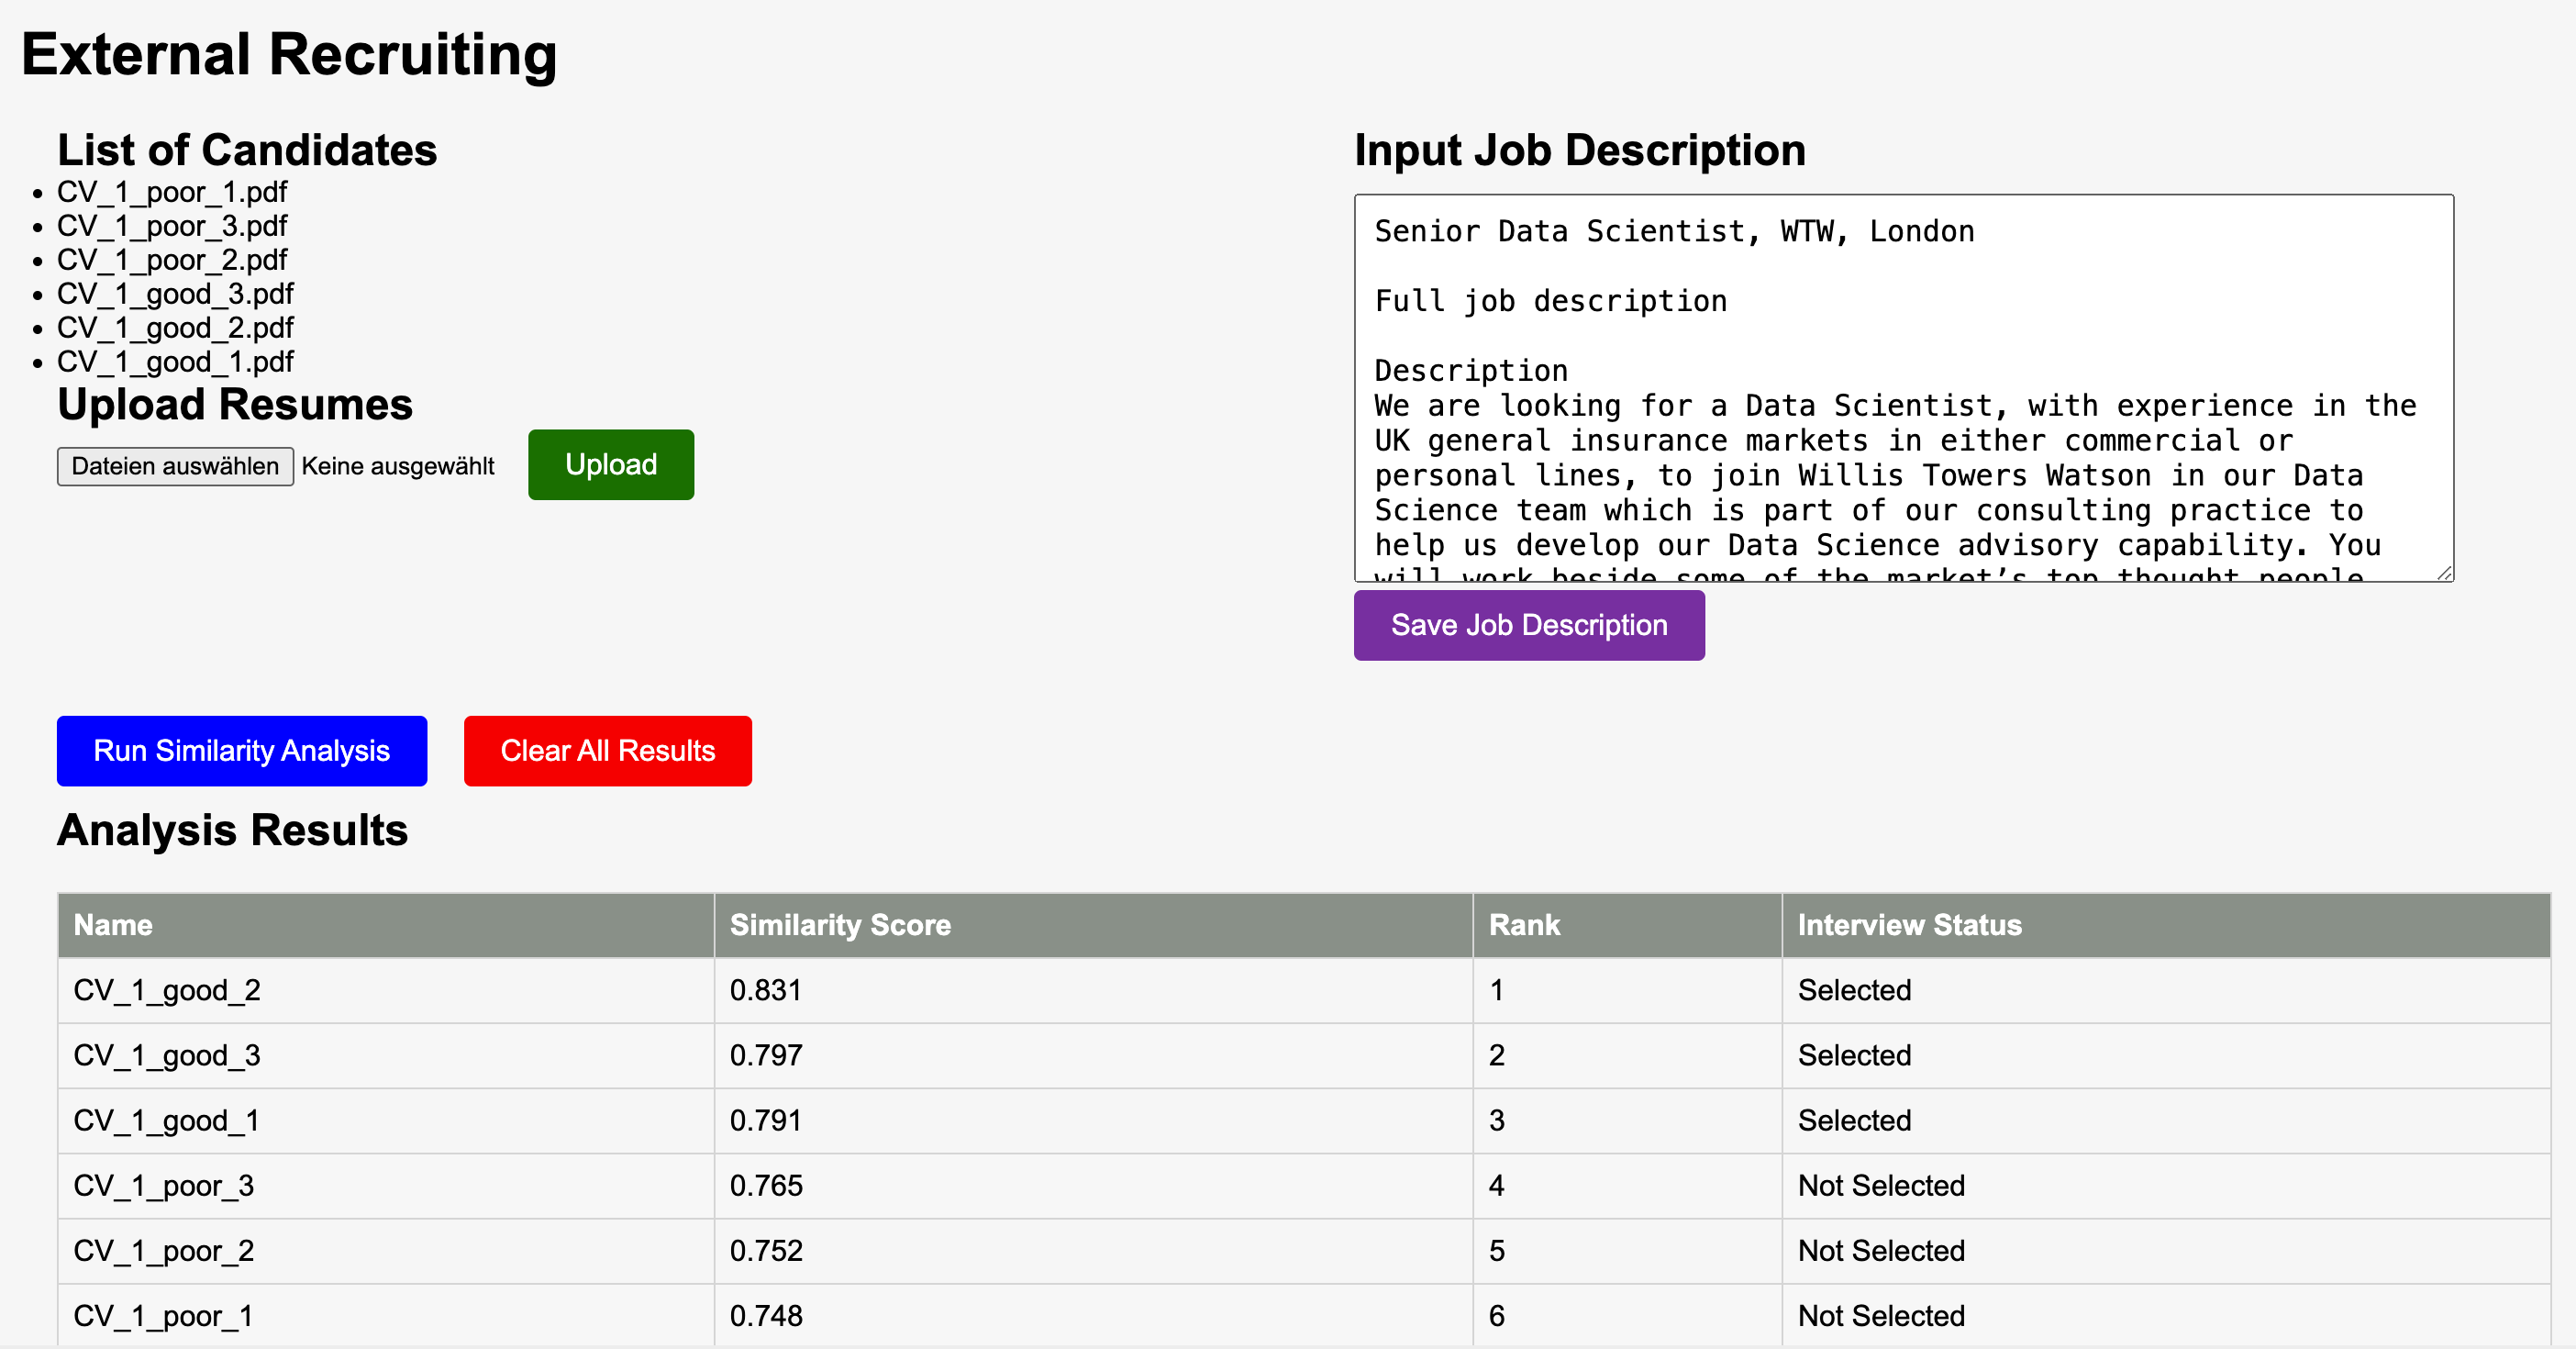

### 2.2 Second Attempt - Adjusted promt *with explanation*

**Specs:**
- 1 Promt generating 3 resumes: No rank, **ALL "almost perfect fit"**
- 1 Promt generating 3 resumes: No rank, **ALL "bad fit"**
- Resumes **include explanation** of given fit to analyze reasoning

#### 2.2.1 Almost perfect fit resumes (No ranking)

In [11]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
At the end of the resume, include an explanation of how you generated the resumes in order to achive a high fit with the job description.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,"**John Doe** \nLondon, UK \nEmail: johndoe@e...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,**Candidate Name:** Emma Johnson \n**Contact ...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,**Candidate Name:** Elizabeth Stone \n**Locat...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Resume of Emily Carter** \n[Your Phone Numb...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,"**John Doe** \nLondon, UK \nEmail: john.doe@...",2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,**Resume**\n\n**Alice Thompson** \n[Your Addr...,3


In [12]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_6_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.2.2 Bad fit resumes (No ranking)

In [13]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
At the end of the resume, include an explanation of how you generated the resumes in order to achive a bad fit with the job description.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Candidate Name:** Alex Johnson \n**Address:...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,**Resume** \n---\n\n**Johnathan D. Fields** ...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume for Maxine Robinson**\n\n---\n\n**Max...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Resume: Lisa Tran**\n\n**Contact Information...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume**\n\n**Name:** Jane Doe \n**Address:...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,**Resume**\n\n**Name:** Amir Johnson \n**Addr...,3


In [14]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_6_binary"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)


### 2.3 Third Attempt - Adjusted promt *without explanation*

**Specs:**

- 1 Promt generating 3 resumes: No rank, ALL "almost perfect fit"
- 1 Promt generating 3 resumes: No rank, ALL "bad fit"
- Resumes **DON'T include explanation** of given fit

#### 2.3.1 Almost perfect fit resumes

In [15]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_good_{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_1,Candidate_1_good_1,"**John Smith** \n[Your Address] \n[City, Zip...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_2,Candidate_1_good_2,"**John Smith** \n[London, UK] \n[Email: john...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_good_3,Candidate_1_good_3,"**John Smith**\nLondon, UK \nEmail: john.smit...",3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_1,Candidate_2_good_1,**Jane Doe** \n[Email: jane.doe@example.com] ...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_2,Candidate_2_good_2,"**John Doe** \n123 Tech Way, London, UK \njo...",2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_good_3,Candidate_2_good_3,"**Resume**\n\n**John Smith** \nLondon, UK \n...",3


In [16]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_7_binary_no_explanation"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.3.2 Bad fit resumes

In [17]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_poor_{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_1,Candidate_1_poor_1,**Johnathan Smith** \n123 Technology Lane \n...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_2,Candidate_1_poor_2,"**John Doe** \n123 Main St, Anytown, UK \njo...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_poor_3,Candidate_1_poor_3,**Resume**\n\n**Jane Doe** \n123 Coastal Rd ...,3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_1,Candidate_2_poor_1,**Resume**\n\n**James Smithson** \nEmail: jam...,1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_2,Candidate_2_poor_2,**Resume: Jordan Smith** \n[Email: jordansmit...,2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_poor_3,Candidate_2_poor_3,**Resume: Marcus Albright**\n\n**Contact Infor...,3


In [18]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_7_binary_no_explanation"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

### 2.4 Fourth Attempt - Adjusted promt *without explanation*

**Specs:**
- 1 Promt generating 3 resumes: No rank, ALL "almost perfect fit"
- 1 Promt generating 3 resumes: No rank, ALL "**slightly bad** fit"

#### 2.4.1 Almost perfect fit resumes

In [26]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,11,Candidate_1_good_1,"**John Smith** \n123 Data Lane \nLondon, UK ...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,12,Candidate_1_good_2,"**John Doe** \n[Your Address] \n[City, Postc...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,13,Candidate_1_good_3,"**Jane Doe** \n[Your Address] \nLondon, UK ...",3
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,21,Candidate_2_good_1,"**John Anderson** \nLondon, UK \njohn.anders...",1
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,22,Candidate_2_good_2,"**Resume**\n\n**Alex Thompson** \nLondon, UK ...",2
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,23,Candidate_2_good_3,"**Resume**\n\n**John Anderson** \nLondon, UK ...",3


In [22]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /good fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data binary/Test_4_slightly_bad"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_good_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.4.2 Slightly bad fit resumes

In [25]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Generate 3 resumes with poor fit
    for rank in range(4, 7):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an slightly bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is slighly bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,14,Candidate_1_poor_4,"**Alexandra Thompson** \nLondon, UK \nalexan...",4
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,15,Candidate_1_poor_5,"**Johnathan Smith** \nLondon, UK \n+44 20 79...",5
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,16,Candidate_1_poor_6,**Johnathan Smith** \n123 Elm Street \nLondo...,6
3,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,24,Candidate_2_poor_4,"**Alex Johnson** \n123 Main Street \nLondon,...",4
4,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,25,Candidate_2_poor_5,"**John Doe** \n123 Tech Lane \nLondon, UK \...",5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,26,Candidate_2_poor_6,"**John Smith** \n123 Tech Lane \nLondon, UK ...",6


In [24]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/synthetic data /bad fit resumes 23.11"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data binary/Test_4_slightly_bad"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes_poor_fit.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

#### 2.4.3 Merging the datasets

In [29]:
import pandas as pd

# Merge the DataFrames
df_synthetic_resumes = pd.concat([df_resumes_good_fit, df_resumes_poor_fit], ignore_index=True)

# Sort the DataFrame based on 'CV ID' in descending order
df_synthetic_resumes_sorted = df_synthetic_resumes.sort_values(by='CV ID', ascending=True).reset_index(drop=True)

# Display the combined and sorted DataFrame
df_synthetic_resumes_sorted

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,11,Candidate_1_good_1,"**John Smith** \n123 Data Lane \nLondon, UK ...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,12,Candidate_1_good_2,"**John Doe** \n[Your Address] \n[City, Postc...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,13,Candidate_1_good_3,"**Jane Doe** \n[Your Address] \nLondon, UK ...",3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,14,Candidate_1_poor_4,"**Alexandra Thompson** \nLondon, UK \nalexan...",4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,15,Candidate_1_poor_5,"**Johnathan Smith** \nLondon, UK \n+44 20 79...",5
5,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,16,Candidate_1_poor_6,**Johnathan Smith** \n123 Elm Street \nLondo...,6
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,21,Candidate_2_good_1,"**John Anderson** \nLondon, UK \njohn.anders...",1
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,22,Candidate_2_good_2,"**Resume**\n\n**Alex Thompson** \nLondon, UK ...",2
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,23,Candidate_2_good_3,"**Resume**\n\n**John Anderson** \nLondon, UK ...",3
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,24,Candidate_2_poor_4,"**Alex Johnson** \n123 Main Street \nLondon,...",4


## 3 LinkedIn tech job descriptions dataset

### 3.1 Dataset Import with Dark

In [83]:
import dask.dataframe as dd

file_path = '/Users/timg/Downloads/jobs.csv'

# Specify the data type for the 'date' column
dtype = {'date': 'object'}

# Read the CSV file using Dask with specified dtype
df_job_descriptions_linkedin = dd.read_csv(file_path, dtype=dtype)

# Compute the number of columns
num_columns = len(df_job_descriptions_linkedin.columns)
print(f'Number of columns: {num_columns}')

# Compute the number of rows
num_rows = df_job_descriptions_linkedin.shape[0].compute()
print(f'Number of rows: {num_rows}')

Number of columns: 18
Number of rows: 8261


In [84]:
df_job_descriptions_linkedin.head()

,Employment type,Industries,Job function,Seniority level,company,company_id,context,date,description,education,location,months_experience,post_id,post_url,sal_high,sal_low,salary,title
0,Full-time,Broadcast Media,Information Technology,Mid-Senior level,CyberCoders,21836.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Job Title: Senior Data Engineer Location: Alex...,bachelor degree,"Alexandria, VA",60.0,2632814552,https://www.linkedin.com/jobs/view/senior-data...,NaN,NaN,NaN,Senior Data Engineer
1,Full-time,"Hospital & Health Care, Medical Devices, and P...",Engineering and Information Technology,Not Applicable,Johnson & Johnson,1207.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,"Ethicon, part of Johnson & Johnson Medical Dev...",bachelor degree,"Santa Clara, CA",96.0,2632810866,https://www.linkedin.com/jobs/view/principal-f...,NaN,NaN,NaN,Principal Full Stack Software Engineer.
2,Full-time,"Computer Hardware, Computer Software, and Info...",Engineering and Information Technology,Not Applicable,Microsoft,1035.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Microsoft’s WCB health team is looking for a S...,bachelor degree,"Washington, DC",84.0,2632812746,https://www.linkedin.com/jobs/view/senior-soft...,189000.0,120000.0,"$120,000.00/yr - $189,000.00/yr",Senior Software Engineer
3,Full-time,"Computer Hardware, Computer Software, and Info...",Engineering and Information Technology,Not Applicable,Microsoft,1035.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Microsoft’s WCB health team is looking for a S...,bachelor degree,"Reston, VA",84.0,2632817427,https://www.linkedin.com/jobs/view/senior-soft...,189000.0,120000.0,"$120,000.00/yr - $189,000.00/yr",Senior Software Engineer
4,Full-time,"Computer Hardware, Computer Software, and Info...",Engineering and Information Technology,Not Applicable,Microsoft,1035.0,"{""@context"": ""http://schema.org"", ""@type"": ""Jo...",NaN,Microsoft’s WCB health team is looking for a S...,bachelor degree,"Irving, TX",84.0,2632817426,https://www.linkedin.com/jobs/view/senior-soft...,175000.0,108000.0,"$108,000.00/yr - $175,000.00/yr",Senior Software Engineer


In [85]:
print(df_job_descriptions_linkedin.columns.tolist())

['Employment type', 'Industries', 'Job function', 'Seniority level', 'company', 'company_id', 'context', 'date', 'description', 'education', 'location', 'months_experience', 'post_id', 'post_url', 'sal_high', 'sal_low', 'salary', 'title']


/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/2699030505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_descriptions_linkedin_date['year'] = df_job_descriptions_linkedin_date['date'].dt.year
/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/2699030505.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette='viridis')


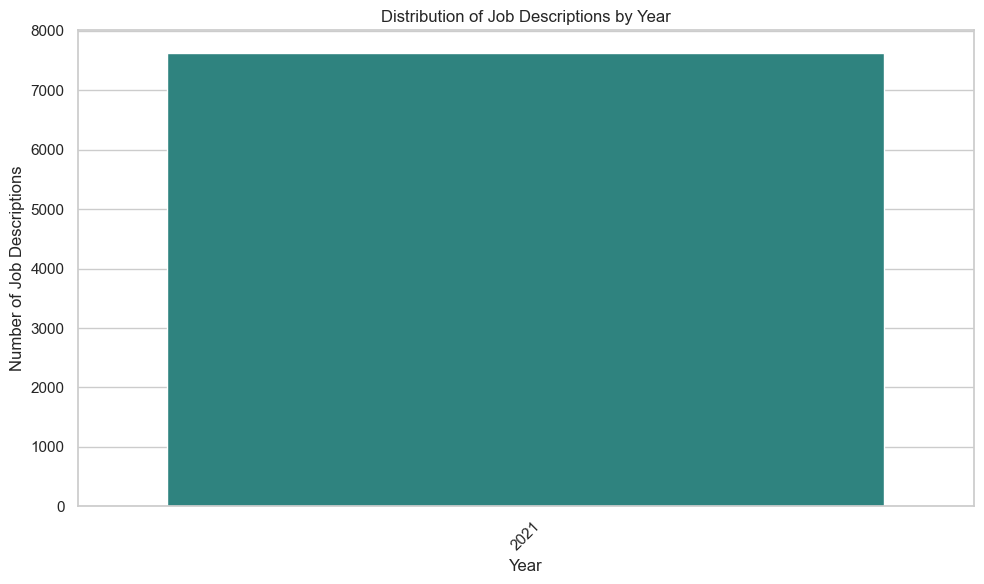

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df_job_descriptions_linkedin = df_job_descriptions_linkedin.compute()

# Step 1: Convert 'date' column to datetime format if it's not already
df_job_descriptions_linkedin['date'] = pd.to_datetime(df_job_descriptions_linkedin['date'], errors='coerce')

# Handle any NaT values (if any dates couldn't be parsed)
df_job_descriptions_linkedin_date = df_job_descriptions_linkedin.dropna(subset=['date'])

# Step 2: Extract the year from the 'date' column and create a new column 'year'
df_job_descriptions_linkedin_date['year'] = df_job_descriptions_linkedin_date['date'].dt.year

# Step 3: Calculate the count of job descriptions per year
year_counts = df_job_descriptions_linkedin_date['year'].value_counts().sort_index()

# Step 4: Plot the distribution of job descriptions by year
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette='viridis')
plt.title('Distribution of Job Descriptions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Job Descriptions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2 Data Preprocessing

#### 3.2.1 Data Subset with 1000 Rows

Columns in df_sample:
Index(['Employment type', 'Industries', 'Job function', 'Seniority level',
       'company', 'company_id', 'context', 'date', 'description', 'education',
       'location', 'months_experience', 'post_id', 'post_url', 'sal_high',
       'sal_low', 'salary', 'title'],
      dtype='object')


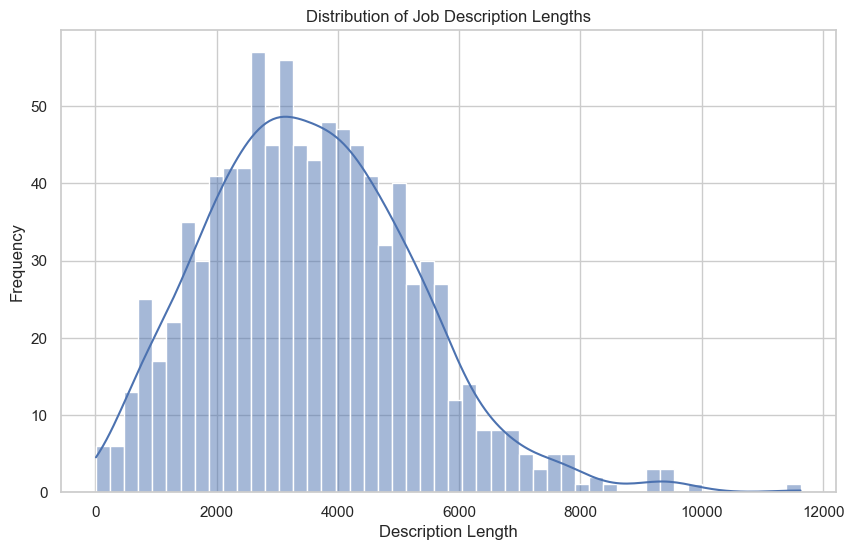

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Sample 1,000 random rows from the Dask DataFrame and convert to pandas DataFrame
total_rows = df_job_descriptions_linkedin.shape[0].compute()
frac = 1000 / total_rows
frac_adjusted = frac * 1.1  # Adjust as needed
df_sample_dd = df_job_descriptions_linkedin.sample(frac=frac_adjusted, random_state=42)
df_sample_pd = df_sample_dd.compute()
df_sample = df_sample_pd.sample(n=1000, random_state=42)

# Step 2: Check the column names
print("Columns in df_sample:")
print(df_sample.columns)

#### 3.2.2 Adjusting the Distribution of Job Description Length

In [ ]:
# Step 1: Add a column "description_length" to the pandas DataFrame
df_sample['description_length'] = df_sample['description'].str.len()

# Step 2: Create a plot showing the distribution of "description_length"
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['description_length'], bins=50, kde=True)
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [87]:
# Using the interquartile range (IQR) to get rid of outliers
Q1 = df_sample['description_length'].quantile(0.25)
Q3 = df_sample['description_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_sample[
    (df_sample['description_length'] >= lower_bound) &
    (df_sample['description_length'] <= upper_bound)
]

# Optionally, reset the index of the filtered DataFrame
df_filtered = df_filtered.reset_index(drop=True)

In [88]:
# Step 1: Calculate mean and standard deviation
mean_length = df_filtered['description_length'].mean()
std_length = df_filtered['description_length'].std()

# Step 2: Determine the upper and lower bounds
lower_bound = mean_length - std_length
upper_bound = mean_length + std_length

# Step 3: Filter the DataFrame to keep rows within one standard deviation
df_filtered_2 = df_filtered[
    (df_filtered['description_length'] >= lower_bound) &
    (df_filtered['description_length'] <= upper_bound)
]

# Optionally, reset the index of the filtered DataFrame
df_filtered_2 = df_filtered_2.reset_index(drop=True)

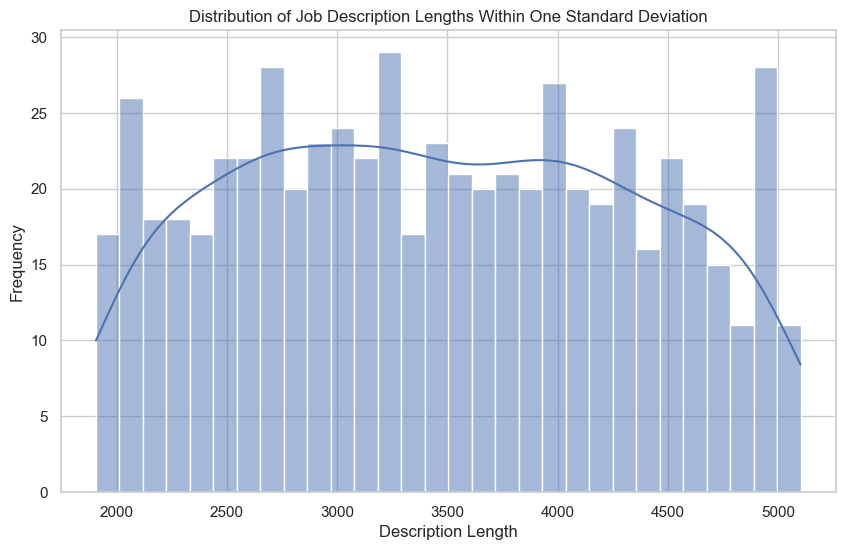

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_filtered_2['description_length'], bins=30, kde=True)
plt.title('Distribution of Job Description Lengths Within One Standard Deviation')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [90]:
num_rows_before = len(df_sample)
num_rows_after = len(df_filtered_2)
rows_dropped = num_rows_before - num_rows_after

print(f"Rows before filtering: {num_rows_before}")
print(f"Rows after filtering: {num_rows_after}")
print(f"Rows dropped: {rows_dropped}")

Rows before filtering: 1000
Rows after filtering: 620
Rows dropped: 380


#### 3.2.3 Dropping unnecessary Columns

In [220]:
df_filtered_2.head()

,Job function,company,date,description,education,location,months_experience,sal_high,sal_low,title,description_length
0,"Marketing, Public Relations, and Writing/Editing",Nepris Inc.,2021-09-01 23:13:04.915228,The volunteer opportunity below is a request f...,NaN,"Sioux Falls, SD",NaN,NaN,NaN,Software Engineer,2066.0
1,Quality Assurance,Lucid Motors,2021-07-29 22:22:13.068249,Leading the future of luxury mobility Lucid’s ...,bachelor degree,"Troy, MI",NaN,NaN,NaN,Restraint System Integration and Testing Engin...,3445.0
2,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0
3,Engineering and Information Technology,Assurant,2021-07-29 22:03:36.459980,The Junior Data Scientist is responsible for u...,bachelor degree,"Covington, GA",24.0,125000.0,60700.0,Data Scientist,4672.0
4,Engineering and Information Technology,Plaid,2021-10-05 11:02:19.883494,We believe that the way people interact with t...,bachelor degree,"New York, NY",NaN,160000.0,65600.0,Software Engineer,3247.0


In [93]:
# List of columns to drop
columns_to_drop = [
    'Employment type', 'Industries', 'Seniority level', 'company_id', 'context', 'post_id', 'post_url', 'salary'
]

# Drop the specified columns
df_filtered_2 = df_filtered_2.drop(columns=columns_to_drop)

# Verify the columns have been dropped
print("Remaining columns in the dataset:")
print(df_filtered_2.columns)

Remaining columns in the dataset:
Index(['Job function', 'company', 'date', 'description', 'education',
       'location', 'months_experience', 'sal_high', 'sal_low', 'title',
       'description_length'],
      dtype='object')


In [110]:
df_filtered_2.head()

,Job function,company,date,description,education,location,months_experience,sal_high,sal_low,title,description_length
0,"Marketing, Public Relations, and Writing/Editing",Nepris Inc.,2021-09-01 23:13:04.915228,The volunteer opportunity below is a request f...,NaN,"Sioux Falls, SD",NaN,NaN,NaN,Software Engineer,2066.0
1,Quality Assurance,Lucid Motors,2021-07-29 22:22:13.068249,Leading the future of luxury mobility Lucid’s ...,bachelor degree,"Troy, MI",NaN,NaN,NaN,Restraint System Integration and Testing Engin...,3445.0
2,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0


### 3.3 Exploratory Data Analysis

#### 3.3.1 Dataset Structure

In [95]:
# Set seaborn style for better visuals
sns.set(style='whitegrid')

In [222]:
# Display the shape of the dataset
print(f"Dataset Shape: {df_filtered_2.shape}")

# Display data types of each column
print("\nData Types:")
print(df_filtered_2.dtypes)

# Display first few rows
print("\nFirst 3 Rows:")
df_filtered_2.head(3)

Dataset Shape: (620, 11)

Data Types:
Job function           object
company                object
date                   object
description            object
education              object
location               object
months_experience     float64
sal_high              float64
sal_low               float64
title                  object
description_length    float64
dtype: object

First 3 Rows:


,Job function,company,date,description,education,location,months_experience,sal_high,sal_low,title,description_length
0,"Marketing, Public Relations, and Writing/Editing",Nepris Inc.,2021-09-01 23:13:04.915228,The volunteer opportunity below is a request f...,NaN,"Sioux Falls, SD",NaN,NaN,NaN,Software Engineer,2066.0
1,Quality Assurance,Lucid Motors,2021-07-29 22:22:13.068249,Leading the future of luxury mobility Lucid’s ...,bachelor degree,"Troy, MI",NaN,NaN,NaN,Restraint System Integration and Testing Engin...,3445.0
2,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0


#### 3.3.2 Missing Values

In [97]:
# Check for missing values in each column
print("\nMissing Values in Each Column:")
print(df_filtered_2.isnull().sum())


Missing Values in Each Column:
Job function           28
company                 0
date                   47
description             0
education              17
location                0
months_experience     183
sal_high              437
sal_low               437
title                   0
description_length      0
dtype: int64


#### 3.3.3 Dataset Description

In [98]:
# Get summary statistics for numerical columns
print("\nStatistical Summary of Numerical Columns:")
print(df_filtered_2.describe())


Statistical Summary of Numerical Columns:
       months_experience       sal_high        sal_low  description_length
count         437.000000     183.000000     183.000000          620.000000
mean           47.917620  152345.879781   93299.377049         3457.638710
std            25.822837   39913.427332   25768.774319          887.554522
min            12.000000   60800.000000   42100.000000         1906.000000
25%            24.000000  122000.000000   74350.000000         2714.000000
50%            48.000000  149700.000000   88200.000000         3437.500000
75%            60.000000  180000.000000  113500.000000         4209.000000
max           144.000000  259900.000000  167000.000000         5102.000000


#### 3.3.4 Variable Distribution

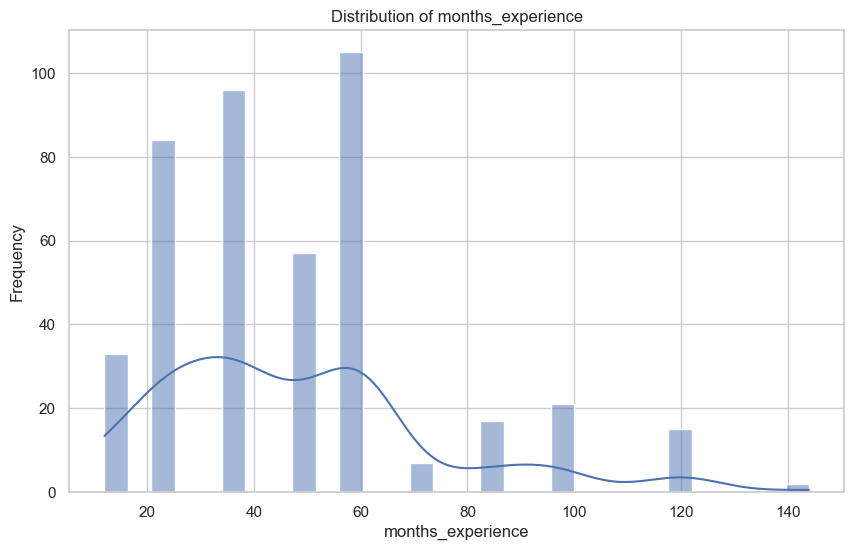

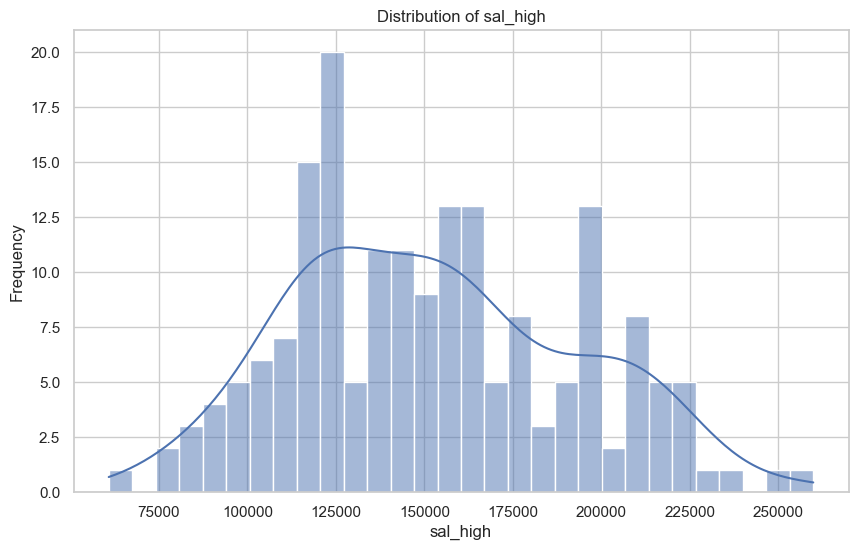

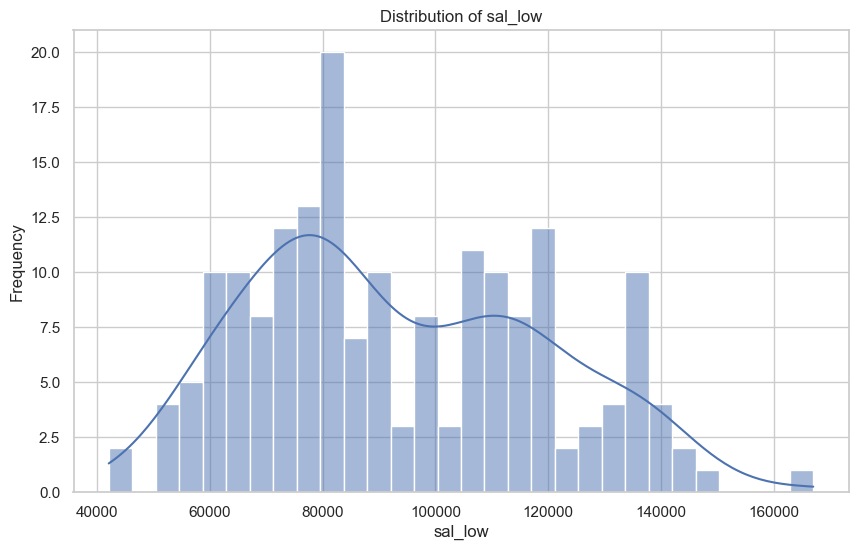

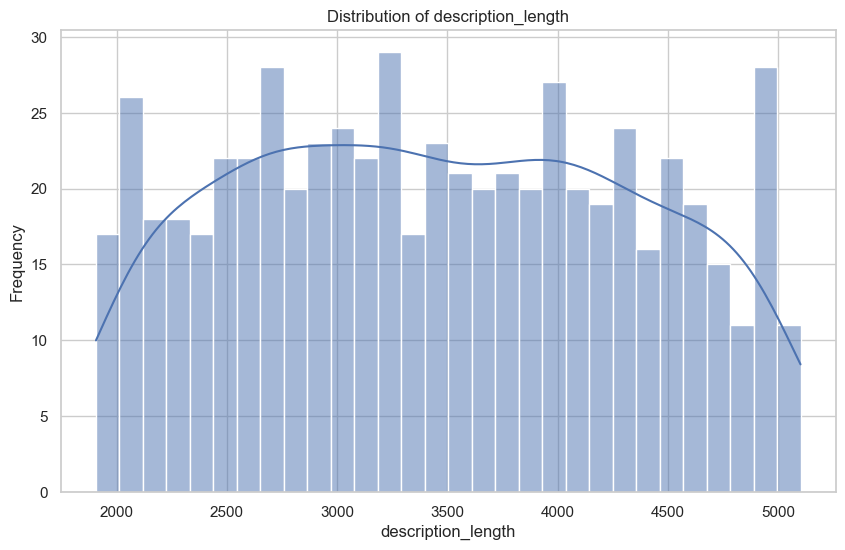

In [100]:
# Identify numerical columns
numerical_columns = df_filtered_2.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_filtered_2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


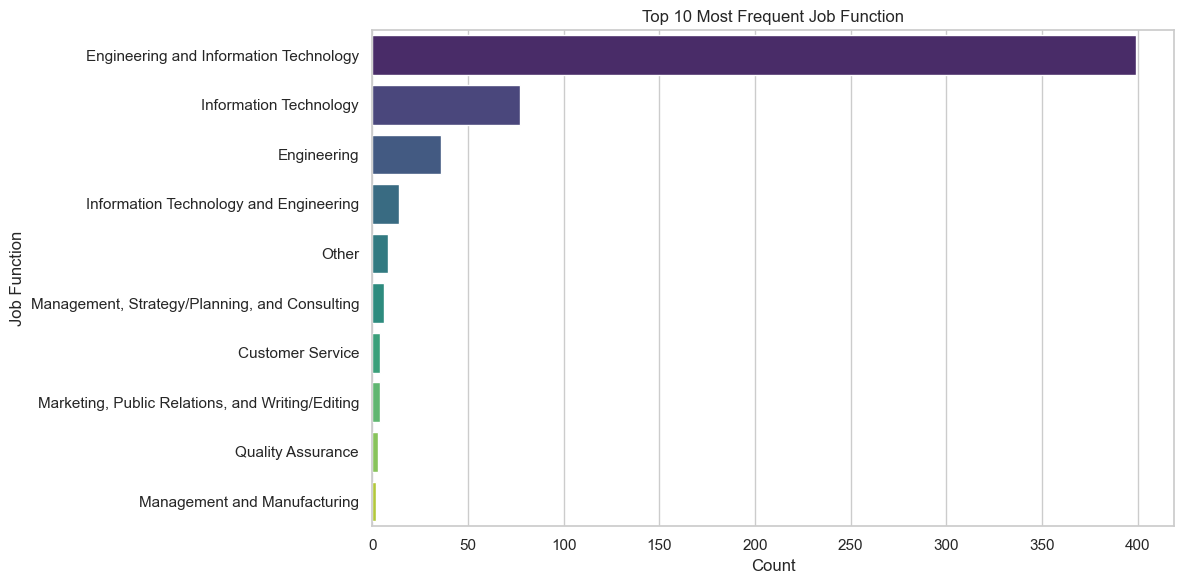

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


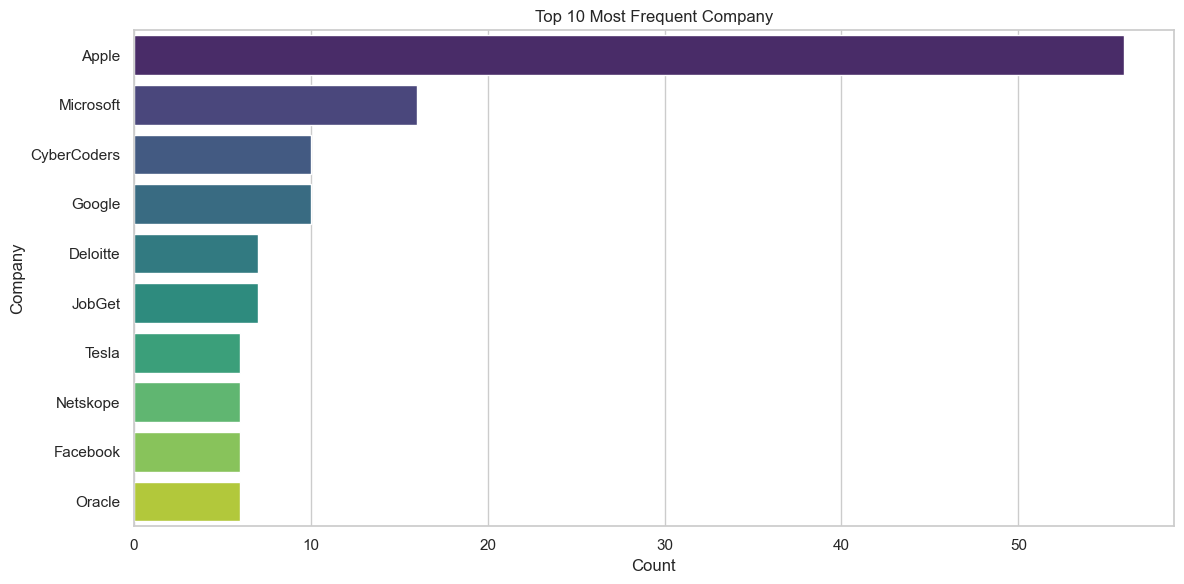

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


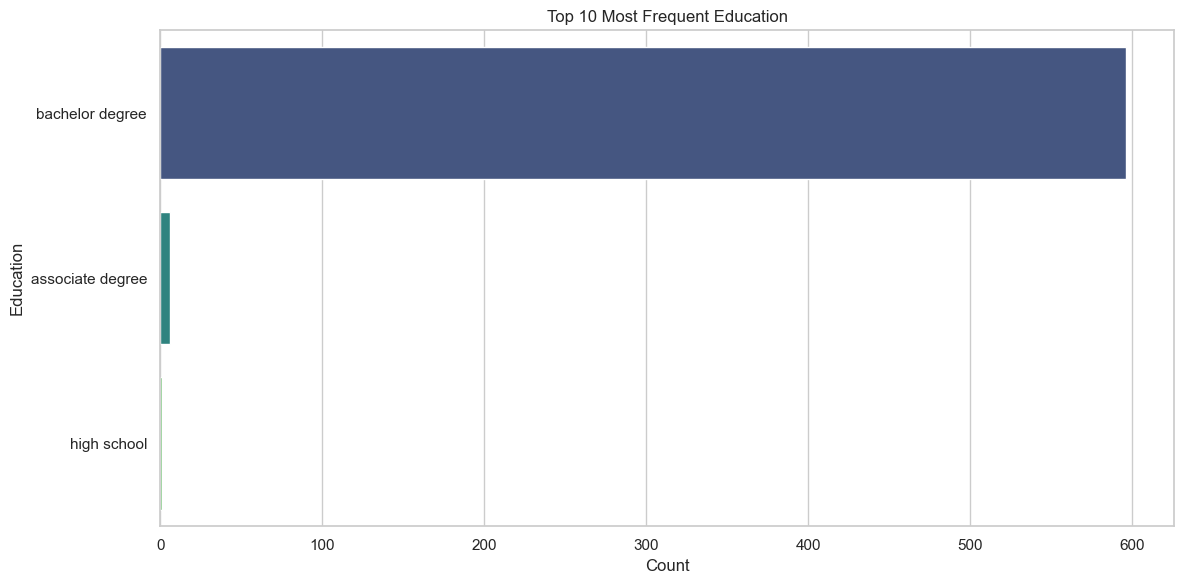

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


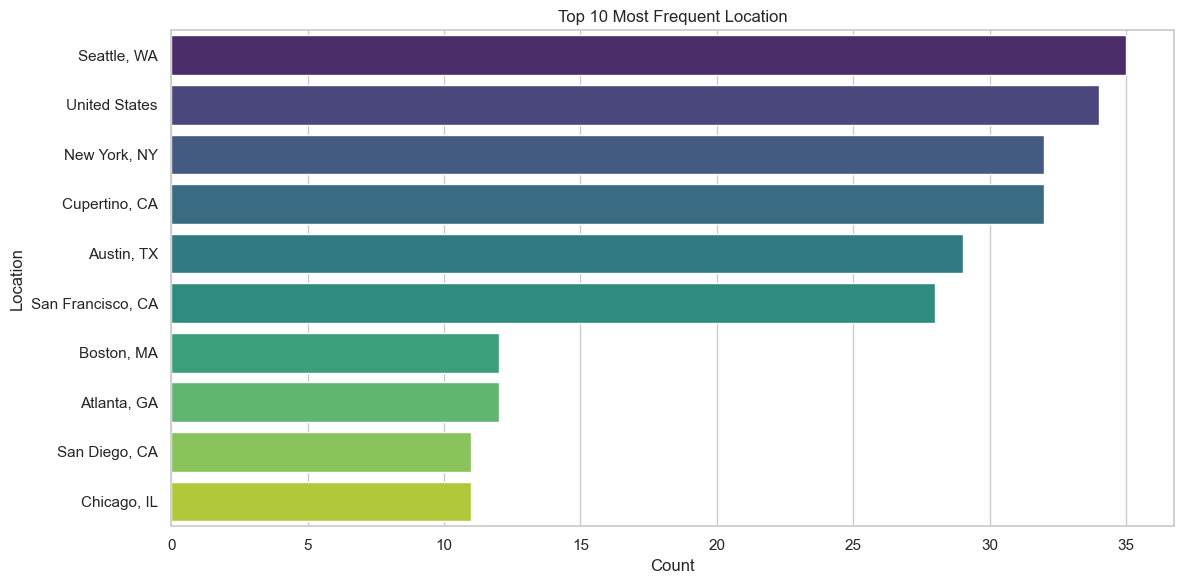

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/4034325876.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


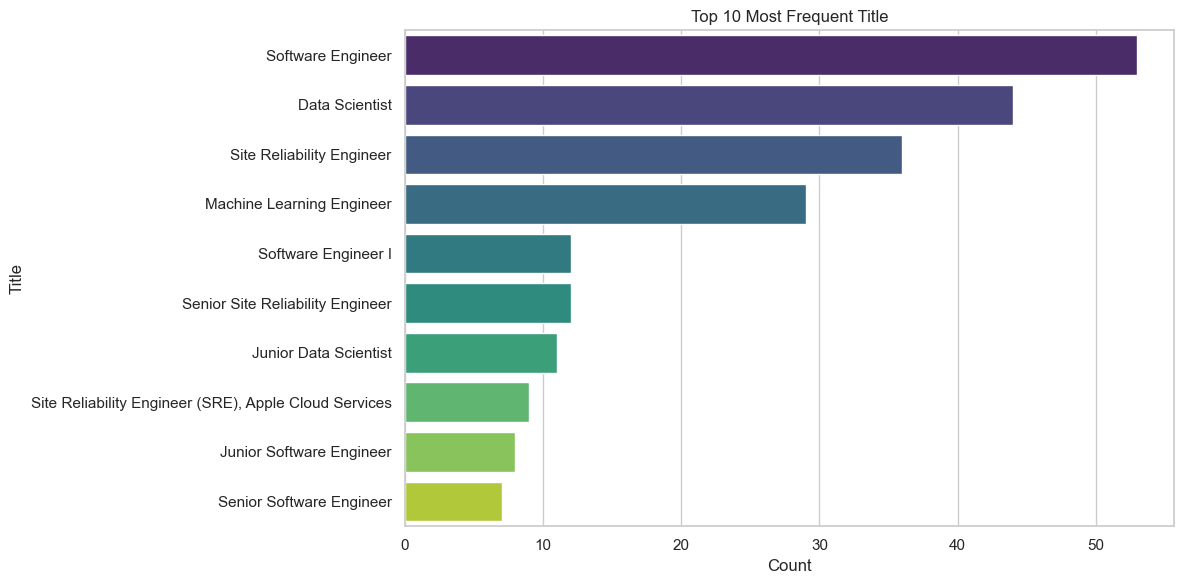

In [101]:
# List of specific categorical columns to plot
categorical_columns_to_plot = ['Job function', 'company', 'education', 'location', 'title']

# Iterate over the specified categorical columns
for col in categorical_columns_to_plot:
    if col in df_filtered_2.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(
            y=df_filtered_2[col],
            order=df_filtered_2[col].value_counts().iloc[:10].index,
            palette='viridis'
        )
        plt.title(f'Top 10 Most Frequent {col.replace("_", " ").title()}')
        plt.xlabel('Count')
        plt.ylabel(col.replace("_", " ").title())
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

#### 3.3.5 Aligning most frequent Job Titles

In [102]:
# Create a dictionary of patterns and replacements
title_consolidation = {
    'Software Engineer': 'Software Engineer',
    'Data Scientist': 'Data Scientist',
    'Data Engineer': 'Data Engineer'
}

# Loop through the dictionary and replace job titles
for pattern, replacement in title_consolidation.items():
    df_filtered_2.loc[
        df_filtered_2['title'].str.contains(pattern, case=False, na=False),
        'title'
    ] = replacement

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/2784649280.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')


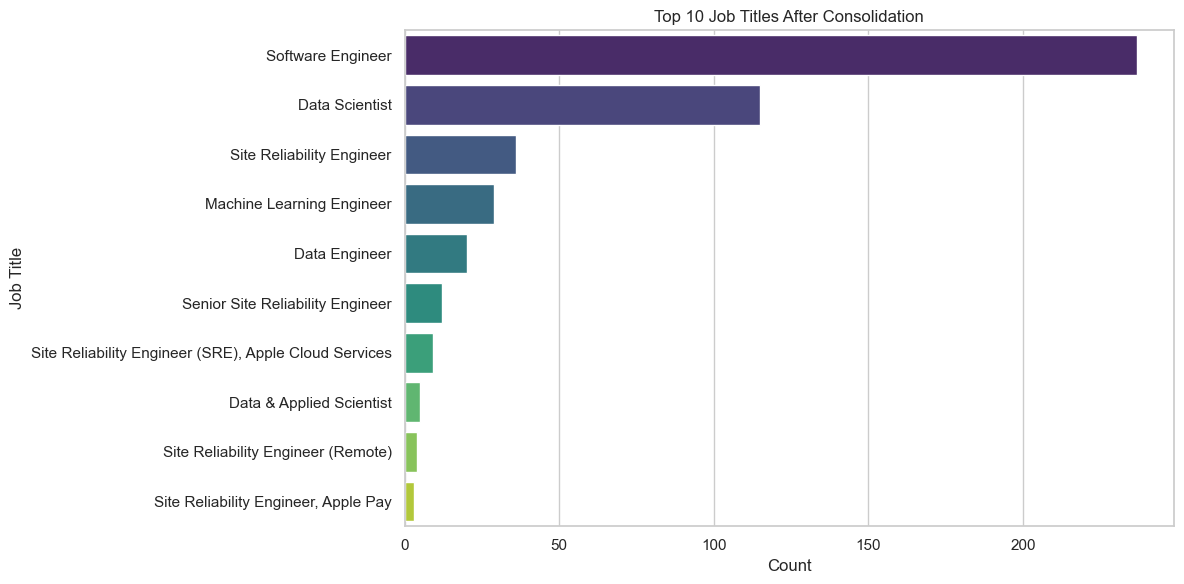

In [103]:
# Plot the top 10 job titles after consolidation
top_job_titles = df_filtered_2['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')
plt.title('Top 10 Job Titles After Consolidation')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

#### 3.3.6 Extracting Skills using the Model Pipeline Logic with the Skills Dictionary and SpaCy

In [200]:
import sys
import os
import pandas as pd
from spacy.lang.en import English

# Step 1: Add the directory containing JobInfoExtraction.py to the Python path
module_path = '/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/services'

if module_path not in sys.path:
    sys.path.append(module_path)

# Step 2: Import the JobInfoExtraction class
from JobInfoExtraction import JobInfoExtraction

# Step 3: Define the path to your skills patterns file
skills_patterns_path = '/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/Resources/data/skills.jsonl'

# Step 4: Instantiate the JobInfoExtraction class
jie = JobInfoExtraction(skills_patterns_path)

# Step 5: Rename the job description column to 'raw' if necessary
df_with_skills = df_filtered_2.rename(columns={'description': 'raw'})

# Step 6: Apply the extract_entities method
df_with_skills = jie.extract_entities(df_with_skills)

In [201]:

# View the extracted skills
df_with_skills[['raw', 'Skills']].head()

,raw,Skills
0,The volunteer opportunity below is a request f...,"[operations research, software engineering, tr..."
1,Leading the future of luxury mobility Lucid’s ...,"[system integration, testing, operations resea..."
2,About The Team Position Summary... What you'll...,"[machine learning, modelling, testing, big dat..."
3,The Junior Data Scientist is responsible for u...,"[business, machine learning tools, python, c, ..."
4,We believe that the way people interact with t...,"[c, software engineering, distributed system, ..."


In [224]:
df_with_skills.iloc[1, 11]

['system integration',
 'testing',
 'operations research',
 'design',
 'database',
 'component',
 'mechanical engineering',
 'engineering',
 'communications']

#### 3.3.7 Adjusting the Distribution of Number of Skills

In [203]:
# Add a new column "number_skills" to count the number of skills
df_with_skills['number_skills'] = df_with_skills['Skills'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Display the updated DataFrame
df_with_skills.head()

,Job function,company,date,raw,education,location,months_experience,sal_high,sal_low,title,description_length,Skills,number_skills
0,"Marketing, Public Relations, and Writing/Editing",Nepris Inc.,2021-09-01 23:13:04.915228,The volunteer opportunity below is a request f...,NaN,"Sioux Falls, SD",NaN,NaN,NaN,Software Engineer,2066.0,"[operations research, software engineering, tr...",3
1,Quality Assurance,Lucid Motors,2021-07-29 22:22:13.068249,Leading the future of luxury mobility Lucid’s ...,bachelor degree,"Troy, MI",NaN,NaN,NaN,Restraint System Integration and Testing Engin...,3445.0,"[system integration, testing, operations resea...",9
2,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0,"[machine learning, modelling, testing, big dat...",28
3,Engineering and Information Technology,Assurant,2021-07-29 22:03:36.459980,The Junior Data Scientist is responsible for u...,bachelor degree,"Covington, GA",24.0,125000.0,60700.0,Data Scientist,4672.0,"[business, machine learning tools, python, c, ...",49
4,Engineering and Information Technology,Plaid,2021-10-05 11:02:19.883494,We believe that the way people interact with t...,bachelor degree,"New York, NY",NaN,160000.0,65600.0,Software Engineer,3247.0,"[c, software engineering, distributed system, ...",11


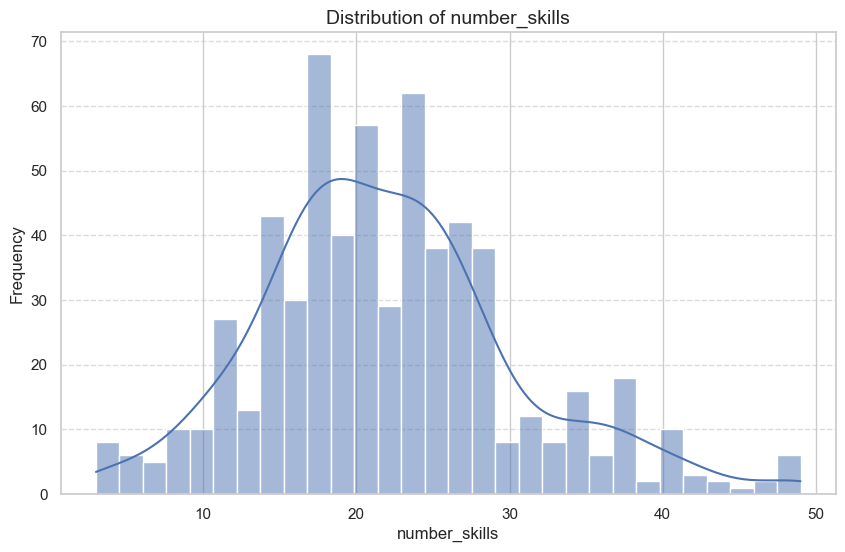

In [204]:
# Define the column to plot
col = 'number_skills'

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(df_with_skills[col], bins=30, kde=True)
plt.title(f'Distribution of {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [205]:
# Using the interquartile range (IQR) to get rid of outliers
Q1 = df_with_skills['number_skills'].quantile(0.25)
Q3 = df_with_skills['number_skills'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_with_skills_filtered = df_with_skills[
    (df_with_skills['number_skills'] >= lower_bound) &
    (df_with_skills['number_skills'] <= upper_bound)
]

# Optionally, reset the index of the filtered DataFrame
df_with_skills_filtered = df_with_skills_filtered.reset_index(drop=True)

In [206]:
# Step 1: Calculate mean and standard deviation
mean_length = df_with_skills_filtered['number_skills'].mean()
std_length = df_with_skills_filtered['number_skills'].std()

# Step 2: Determine the upper and lower bounds
lower_bound = mean_length - std_length
upper_bound = mean_length + std_length

# Step 3: Filter the DataFrame to keep rows within one standard deviation
df_with_skills_filtered_2 = df_with_skills_filtered[
    (df_with_skills_filtered['number_skills'] >= lower_bound) &
    (df_with_skills_filtered['number_skills'] <= upper_bound)
]

# Optionally, reset the index of the filtered DataFrame
df_with_skills_filtered_2 = df_with_skills_filtered_2.reset_index(drop=True)

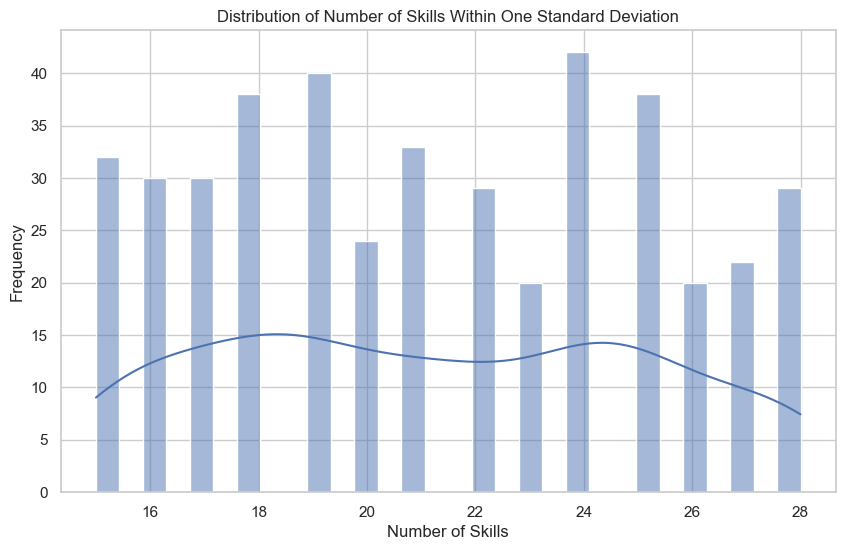

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_with_skills_filtered_2['number_skills'], bins=30, kde=True)
plt.title('Distribution of Number of Skills Within One Standard Deviation')
plt.xlabel('Number of Skills')
plt.ylabel('Frequency')
plt.show()

In [208]:
df_with_skills_filtered_2.head()

,Job function,company,date,raw,education,location,months_experience,sal_high,sal_low,title,description_length,Skills,number_skills
0,Engineering and Information Technology,Walmart,2021-07-19 22:51:59.132023,About The Team Position Summary... What you'll...,bachelor degree,"Carlsbad, CA",48.0,151000.0,77500.0,Data Scientist,4461.0,"[machine learning, modelling, testing, big dat...",28
1,Information Technology,Employa,NaN,Agile Systems Engineer/Software Engineer We ar...,bachelor degree,"Virginia, United States",NaN,NaN,NaN,Software Engineer,3905.0,"[agile project management, systems engineering...",18
2,Engineering and Information Technology,Okta,2021-08-02 20:33:35.398963,Okta is an enterprise grade identity managemen...,bachelor degree,"Chicago, IL",120.0,NaN,NaN,"Principal Software Identity Engineer, Customer...",4502.0,"[operations research, authentication, backend,...",27
3,Engineering and Information Technology,Apex Systems,2021-08-23 18:59:55.017305,"Position: Data Scientist Location: Irvine, CA ...",bachelor degree,"Irvine, CA",60.0,140000.0,110000.0,Data Scientist,2174.0,"[operations research, sql, python, analytics, ...",21
4,Information Technology,Harris,2021-08-25 10:32:09.068344,"As a Senior ERP Application Specialist, you wi...",bachelor degree,"Minneapolis–Saint Paul, MN",36.0,NaN,NaN,Senior ERP Application Specialist,3937.0,"[business, documentation, data validation, tes...",18


In [209]:
df_with_skills_filtered_2.shape

(427, 13)

#### 3.3.8 Reducing overrepresented Job Titles for a more even Distribution

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/3460742369.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')


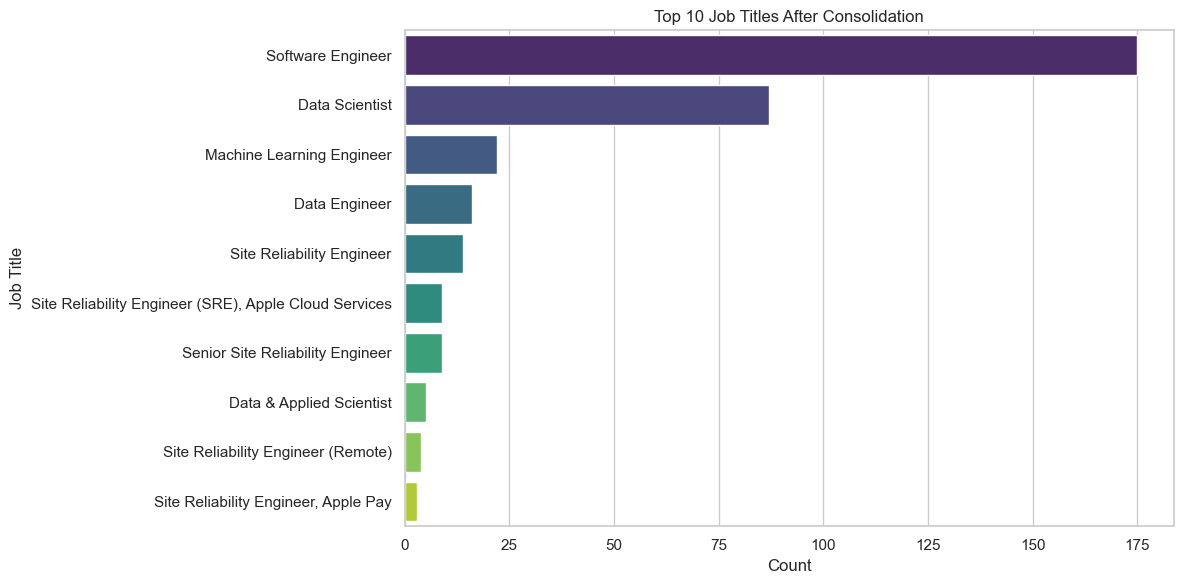

In [210]:
# Plot the top 10 job titles after consolidation
top_job_titles = df_with_skills_filtered_2['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')
plt.title('Top 10 Job Titles After Consolidation')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

In [211]:
# Count occurrences of "Software Engineer" and "Data Scientist" in the "title" column
software_engineer_count = df_with_skills_filtered_2['title'].str.contains('Software Engineer', case=False, na=False).sum()
data_scientist_count = df_with_skills_filtered_2['title'].str.contains('Data Scientist', case=False, na=False).sum()

# Display the counts
print(f"Number of 'Software Engineer': {software_engineer_count}")
print(f"Number of 'Data Scientist': {data_scientist_count}")

Number of 'Software Engineer': 175
Number of 'Data Scientist': 87


In [212]:
# Filter rows where "title" is NOT "Software Engineer" or "Data Scientist"
non_engineer_or_scientist_count = df_with_skills_filtered_2[~df_with_skills_filtered_2['title'].str.contains(
    'Software Engineer|Data Scientist', case=False, na=False)].shape[0]

# Display the count
print(f"Number of rows excluding 'Software Engineer' and 'Data Scientist': {non_engineer_or_scientist_count}")

Number of rows excluding 'Software Engineer' and 'Data Scientist': 165


In [213]:
# Filter rows containing "Software Engineer" and "Data Scientist"
software_engineer_rows = df_with_skills_filtered_2[df_with_skills_filtered_2['title'].str.contains('Software Engineer', case=False, na=False)]
data_scientist_rows = df_with_skills_filtered_2[df_with_skills_filtered_2['title'].str.contains('Data Scientist', case=False, na=False)]

# Randomly sample half of each set
software_engineer_half = software_engineer_rows.sample(frac=0.7, random_state=42)
data_scientist_half = data_scientist_rows.sample(frac=0.5, random_state=42)

# Combine the rows to drop
rows_to_drop = pd.concat([software_engineer_half, data_scientist_half])

# Drop the selected rows from the original DataFrame
df_with_skills_filtered_2_reduced = df_with_skills_filtered_2.drop(rows_to_drop.index)

# Display the resulting DataFrame
df_with_skills_filtered_2_reduced.head()

,Job function,company,date,raw,education,location,months_experience,sal_high,sal_low,title,description_length,Skills,number_skills
2,Engineering and Information Technology,Okta,2021-08-02 20:33:35.398963,Okta is an enterprise grade identity managemen...,bachelor degree,"Chicago, IL",120.0,NaN,NaN,"Principal Software Identity Engineer, Customer...",4502.0,"[operations research, authentication, backend,...",27
3,Engineering and Information Technology,Apex Systems,2021-08-23 18:59:55.017305,"Position: Data Scientist Location: Irvine, CA ...",bachelor degree,"Irvine, CA",60.0,140000.0,110000.0,Data Scientist,2174.0,"[operations research, sql, python, analytics, ...",21
4,Information Technology,Harris,2021-08-25 10:32:09.068344,"As a Senior ERP Application Specialist, you wi...",bachelor degree,"Minneapolis–Saint Paul, MN",36.0,NaN,NaN,Senior ERP Application Specialist,3937.0,"[business, documentation, data validation, tes...",18
5,Engineering and Information Technology,A1A Recruiting,2021-08-20 16:23:36.473163,"Fast growing, stable company with tremendous g...",bachelor degree,"Austin, Texas Metropolitan Area",96.0,NaN,NaN,Data Scientist,2389.0,"[engineering, data science, operations researc...",23
6,Engineering and Information Technology,CharterUP,2021-08-20 16:31:24.942733,About CharterUP We aim to be the leading chart...,bachelor degree,"Austin, TX",NaN,NaN,NaN,Software Engineer,4216.0,"[software engineering, software, agile project...",15


In [214]:
df_with_skills_filtered_2_reduced.shape

(261, 13)

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/1790138635.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')


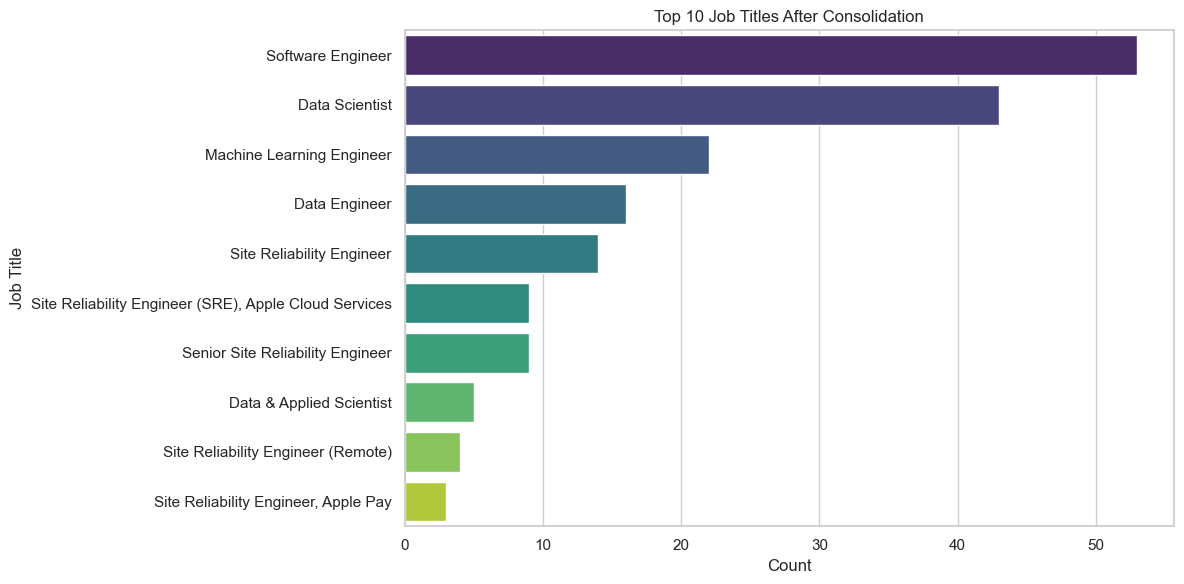

In [215]:
# Plot the top 10 job titles after consolidation
top_job_titles = df_with_skills_filtered_2_reduced['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='viridis')
plt.title('Top 10 Job Titles After Consolidation')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

### 3.4 Final Dataset (Random Subset with 100 Job Descriptions)

#### 3.4.1 Creating a random Subset with 100 JDs

In [216]:
df_final_100 = df_with_skills_filtered_2_reduced.sample(n=min(100, len(df_with_skills)), random_state=42)

In [217]:
df_final_100.shape

(100, 13)

#### 3.4.2 Variable Distribution

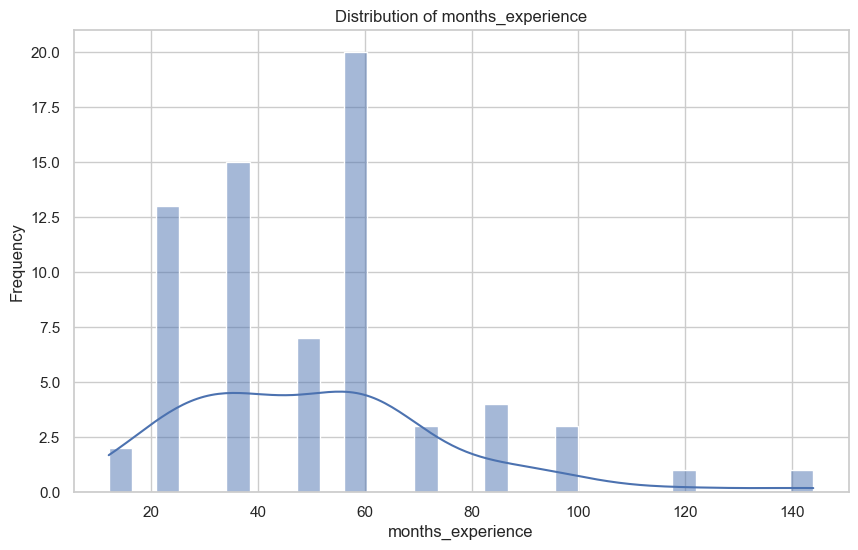

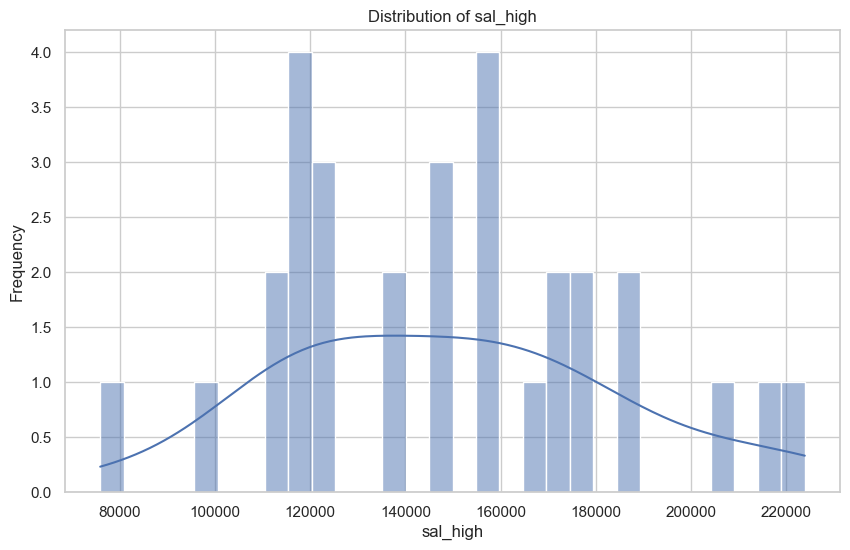

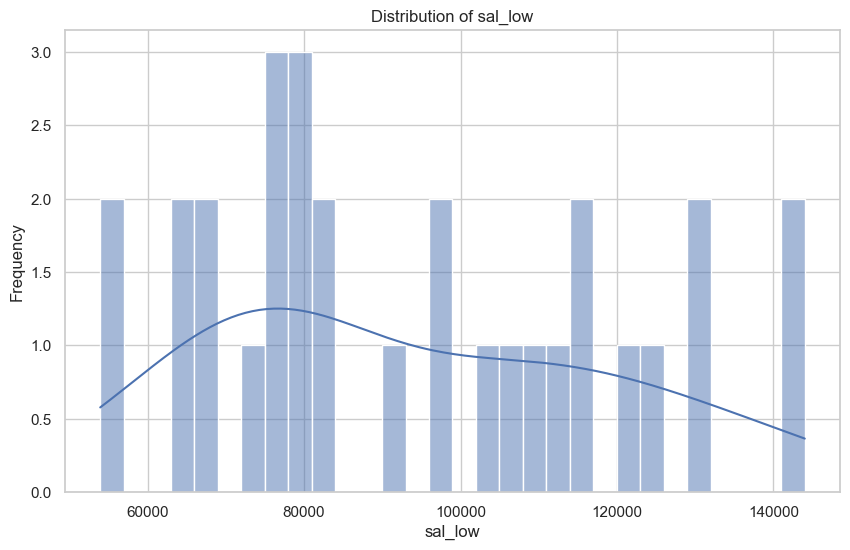

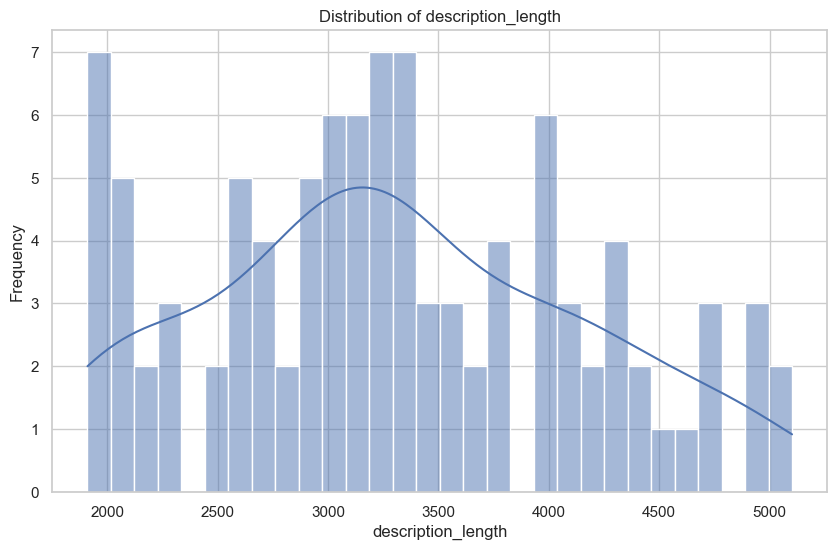

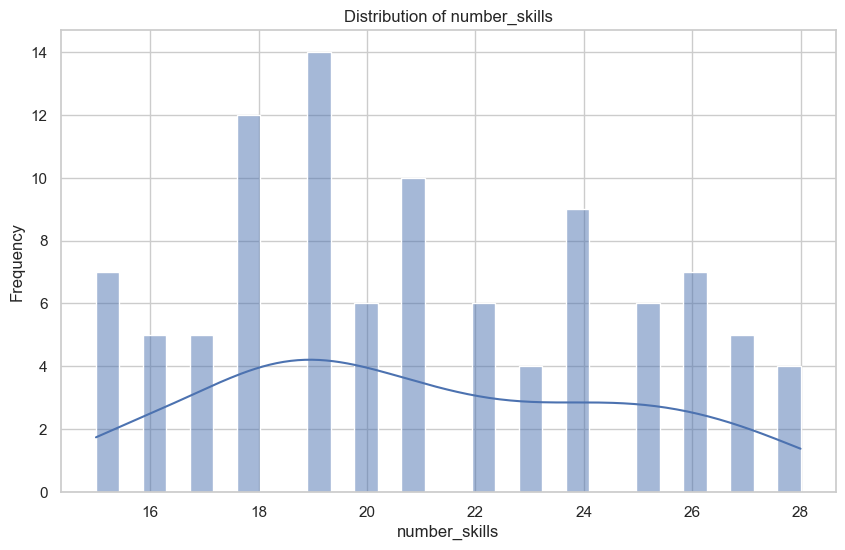

In [218]:
# Identify numerical columns
numerical_columns = df_final_100.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_final_100[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/326054944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


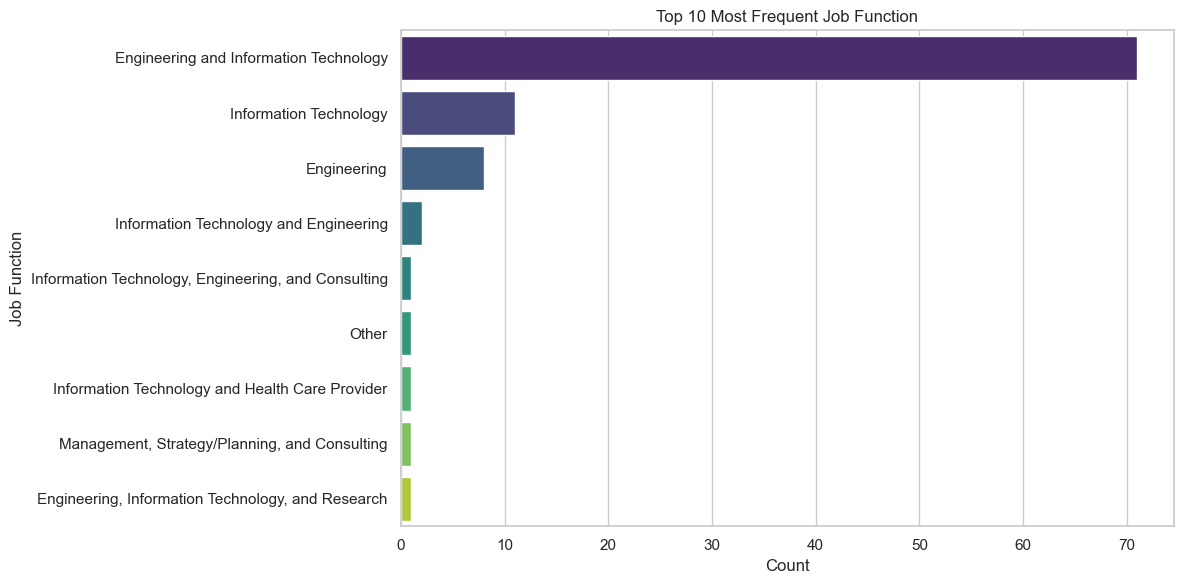

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/326054944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


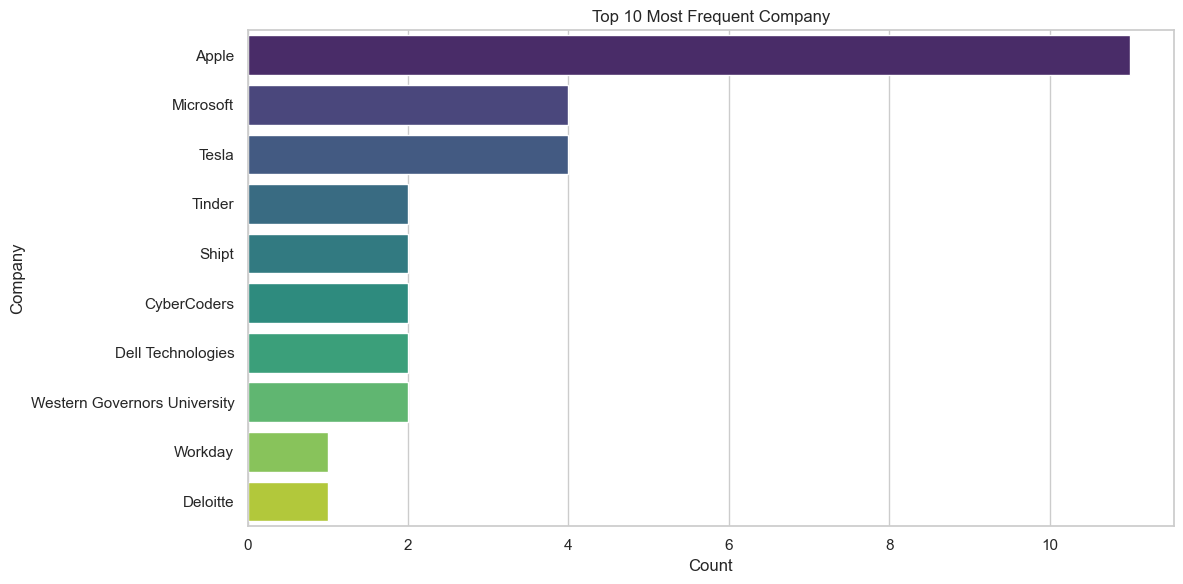

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/326054944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


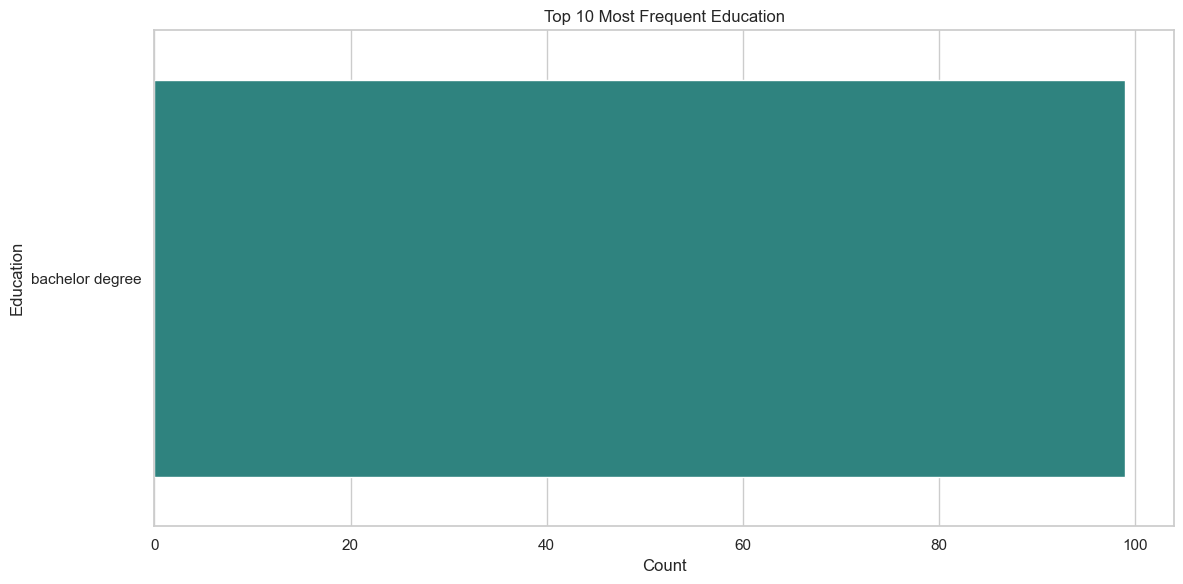

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/326054944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


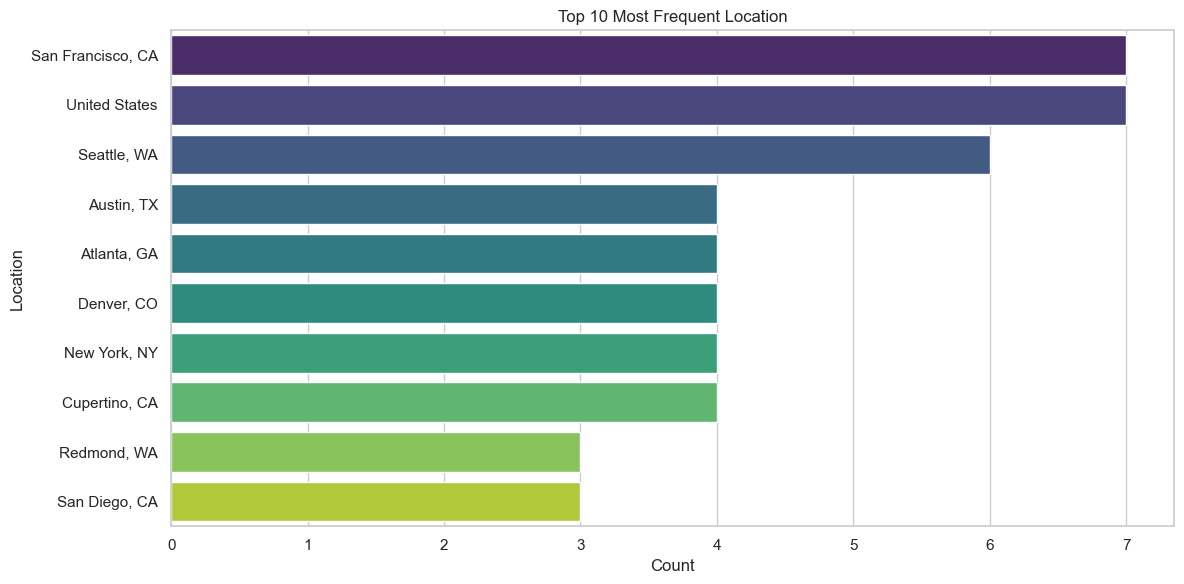

/var/folders/5m/3xn_bfk5365dly9wrvdt_fc40000gn/T/ipykernel_18308/326054944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


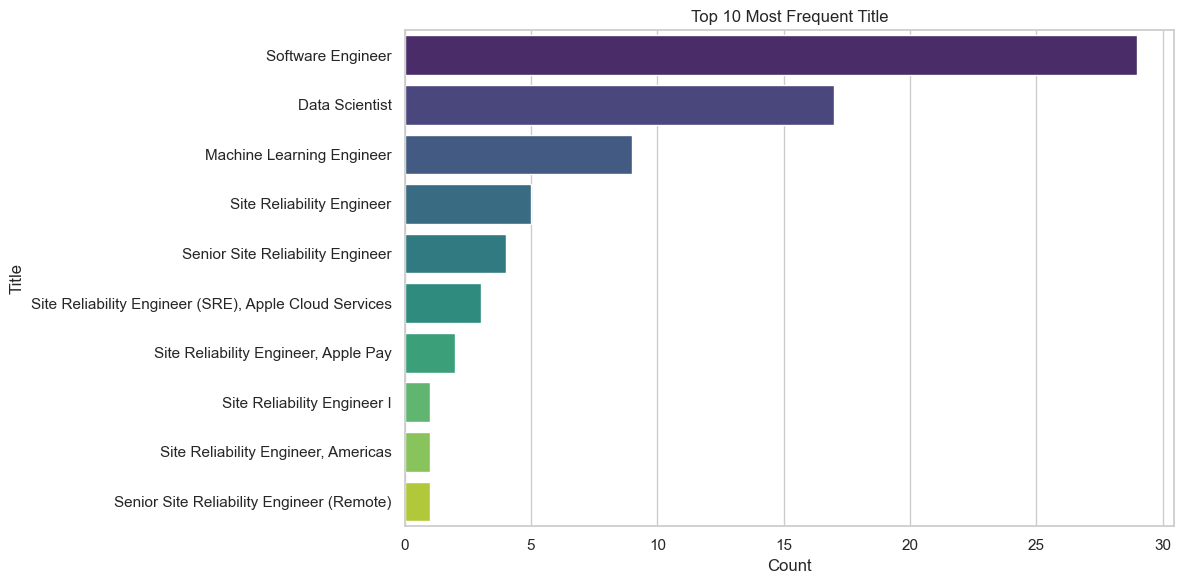

In [219]:
# List of specific categorical columns to plot
categorical_columns_to_plot = ['Job function', 'company', 'education', 'location', 'title']

# Iterate over the specified categorical columns
for col in categorical_columns_to_plot:
    if col in df_final_100.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(
            y=df_final_100[col],
            order=df_final_100[col].value_counts().iloc[:10].index,
            palette='viridis'
        )
        plt.title(f'Top 10 Most Frequent {col.replace("_", " ").title()}')
        plt.xlabel('Count')
        plt.ylabel(col.replace("_", " ").title())
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

### 3.5 Final Dataset for Synthetic Data Generation

#### 3.5.1 Dropping unnecessary Columns

In [232]:
# Create a new DataFrame with only "title" and "raw" columns, reordered
df_job_descriptions_100 = df_final_100[['title', 'raw']]

# Rename the columns
df_job_descriptions_100 = df_job_descriptions_100.rename(
    columns={
        'title': 'Job_title',
        'raw': 'Job_description'
    }
)

# Reset the index
df_job_descriptions_100 = df_job_descriptions_100.reset_index(drop=True)

# Add a new "Job_ID" column at the beginning, starting from 1
df_job_descriptions_100.insert(0, 'Job_ID', range(1, len(df_job_descriptions_100) + 1))

# Display the resulting DataFrame structure
df_job_descriptions_100.head()

,Job_ID,Job_title,Job_description
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...
1,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...
2,3,Site Reliability Engineer,"In Microsoft Health Next, our team is transfor..."
3,4,Sr Site Reliability Engineer,Tesla Cloud Engineering group is looking for a...
4,5,Machine Learning Engineer,Tinder connects people. With tens of millions ...


## 4 First Attempt: Synthetic Data Generation

**Specs:**
- 100 JDs a 6 CVs
- 1 Promt generating 3 resumes: No rank, ALL **"almost perfect fit"**
- 1 Promt generating 3 resumes: No rank, ALL **"slightly bad fit"**

### 4.1 Almost perfect fit Resumes

In [237]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_100.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit_final = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit_final

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,Candidate_1_good_1,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,Candidate_1_good_2,**John Smith** \n[LinkedIn Profile] | [Github...,2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,Candidate_1_good_3,**John D. Anderson** \n123 Tech Lane \nSan F...,3
3,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,Candidate_2_good_1,"**John D. Smith** \n[Your Address] \n[City, ...",1
4,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,Candidate_2_good_2,"**Jessica M. Anderson** \nDenver, CO 80202 \...",2
...,...,...,...,...,...,...,...
295,99,Software Engineer,SeatGeek is building the future of live events...,992,Candidate_99_good_2,**Johnathan Smith** \n123 Technology Way \nS...,2
296,99,Software Engineer,SeatGeek is building the future of live events...,993,Candidate_99_good_3,"**John Smith** \n123 Main St, Boston, MA 0211...",3
297,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1001,Candidate_100_good_1,**John Doe** \n[Email: johndoe@example.com] ...,1
298,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,Candidate_100_good_2,"**John Smith** \n123 Tech Drive \nSan Jose, ...",2


In [253]:
df_resumes_good_fit_final.dtypes

Job Description ID       int64
Job Title               object
Job description text    object
CV ID                   object
CV name                 object
CV                      object
Rank                     int64
dtype: object

In [240]:
df_resumes_good_fit_final.iloc[0,2]

"About the Team Workday is building a new SRE team responsible for deploying, operating and supporting a state of the art cloud native service platform. The platform is built using Cloud Native (https://www.cncf.io/) technologies, on a foundation of Kubernetes in both Public Cloud and Private Cloud environments. This provides a secure platform on which dozens of Workday service teams, and Platform development teams can build and test their pre-release code, through deployment to production on a continuous basis. About the Role The primary function of the SRE team is to ensure the reliability and availability of the platform to meet the desired SLAs, reduce operational load and to scale sustainably in alignment with business growth. We work closely with a dedicated Environment Operations team in supporting the customer facing environments for our end customers including patching our customer environments, and pursuing resolutions to issues found during that patch process. All SRE respon

In [238]:
df_resumes_good_fit_final.iloc[0,5]

'**John Doe**  \n123 Tech Lane  \nPleasanton, CA 94588  \n(555) 123-4567  \njohn.doe@email.com  \n[LinkedIn Profile](https://linkedin.com/in/johndoe)  \n\n---\n\n**Summary**  \nDetail-oriented Senior Site Reliability Engineer with over 5 years of solid experience in managing and troubleshooting distributed systems across multiple cloud platforms. Proven track record of enhancing operational efficiencies through automation and ensuring system reliability to meet SLAs. Proficient in Kubernetes and Linux, with a passion for problem-solving in complex environments.\n\n---\n\n**Professional Experience**  \n\n**Senior Site Reliability Engineer**  \nCloud Innovations Inc., Sunnyvale, CA  \nJune 2019 - Present  \n- Managed and supported a cloud-native service platform built on Kubernetes within both AWS and GCP environments.  \n- Collaborated with cross-functional teams to automate deployment processes, achieving a zero-touch deployment model.  \n- Held accountability for system health, ensuri

### 4.2 Slightly bad Fit Resumes

In [241]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_100.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with poor fit
    for rank in range(4, 7):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an slightly bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is slighly bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit_final = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit_final

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,Candidate_1_poor_4,**John Anderson** \n123 Tech Avenue \nPleasa...,4
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,Candidate_1_poor_5,**John Smith** \n123 Tech Lane \nSan Francis...,5
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,Candidate_1_poor_6,"**Jane Doe**\n\n[Your Address] \n[City, State...",6
3,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,Candidate_2_poor_4,**Resume**\n\n**John Smith** \n123 Tech Lane ...,4
4,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,Candidate_2_poor_5,**Resume of Alex Johnson** \n[Alex.Johnson@em...,5
...,...,...,...,...,...,...,...
295,99,Software Engineer,SeatGeek is building the future of live events...,995,Candidate_99_poor_5,"**Jane Doe** \n[Your Address] \n[City, State...",5
296,99,Software Engineer,SeatGeek is building the future of live events...,996,Candidate_99_poor_6,**John Smith** \n123 Tech Lane \nSan Francis...,6
297,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,Candidate_100_poor_4,"**John Doe** \n[Your Address] \n[City, State...",4
298,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,Candidate_100_poor_5,"**John Doe** \n1234 Elm Street \nCityville, ...",5


In [252]:
df_resumes_poor_fit_final.dtypes

Job Description ID       int64
Job Title               object
Job description text    object
CV ID                   object
CV name                 object
CV                      object
Rank                     int64
dtype: object

### 4.3 Merging the Dataframes

In [273]:
# Merge the dataframes, ensuring all rows are included
merged_df = pd.concat([df_resumes_good_fit_final, df_resumes_poor_fit_final], ignore_index=True)

# Convert CV ID to integer for accurate sorting
merged_df['CV ID'] = merged_df['CV ID'].astype(int)

# Sort the merged dataframe by CV ID
df_synth_data = merged_df.sort_values(by='CV ID')

# Reset the index after sorting
df_synth_data.reset_index(drop=True, inplace=True)

# Display the sorted dataframe
df_synth_data

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,Candidate_1_good_1,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,Candidate_1_good_2,**John Smith** \n[LinkedIn Profile] | [Github...,2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,Candidate_1_good_3,**John D. Anderson** \n123 Tech Lane \nSan F...,3
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,Candidate_1_poor_4,**John Anderson** \n123 Tech Avenue \nPleasa...,4
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,Candidate_1_poor_5,**John Smith** \n123 Tech Lane \nSan Francis...,5
...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,Candidate_100_good_2,"**John Smith** \n123 Tech Drive \nSan Jose, ...",2
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,Candidate_100_good_3,**Resume**\n\n**John Doe** \n123 Main Street ...,3
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,Candidate_100_poor_4,"**John Doe** \n[Your Address] \n[City, State...",4
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,Candidate_100_poor_5,"**John Doe** \n1234 Elm Street \nCityville, ...",5


In [274]:
# Rename and drop columns
df_synth_data = df_synth_data.rename(
    columns={
        "Job Description ID": "JD_ID",
        "Job Title": "JD_title",
        "Job description text": "JD_text",
        "CV ID": "CV_ID",
        "CV": "CV_text",
        "Rank": "label"
    }
)

# Drop the 'CV name' column
df_synth_data = df_synth_data.drop(columns=["CV name"])

# Display the updated dataframe
df_synth_data.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,3
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,4
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,5


In [275]:
# Replace values in the 'Label' column
df_synth_data['label'] = df_synth_data['label'].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0})

# Display the updated dataframe
df_synth_data.head(10)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0
5,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,"**Jane Doe**\n\n[Your Address] \n[City, State...",0
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John D. Smith** \n[Your Address] \n[City, ...",1
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1
8,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,23,"**John Doe** \n[Your Address] \n[City, State...",1
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0


In [276]:
df_synth_data["label"].value_counts()

label
1    300
0    300
Name: count, dtype: int64

In [296]:
df_synth_data.to_csv("/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data.csv", index=False)

## 5 Second Attempt: Synthetic Data Generation

**Specs:**
- **20 JDs** a 6 CVs
- 1 Promt generating 3 resumes: No rank, ALL **"very good fit"**
- 1 Promt generating 3 resumes: No rank, ALL **"moderate fit"**

### 5.1 Subset of JD Dataframe with 20 rows for testing

In [283]:
# Create a random subset with 20 rows
df_job_descriptions_20 = df_job_descriptions_100.sample(n=20, random_state=42)

# Reset the index
df_job_descriptions_20 = df_job_descriptions_20.reset_index(drop=True)

# Rename the Job_ID column to range from 1 to 20
df_job_descriptions_20['Job_ID'] = range(1, 21)

# Display the new subset DataFrame
df_job_descriptions_20.head()

,Job_ID,Job_title,Job_description
0,1,Data Scientist,If you’re passionate about building a better f...
1,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...
2,3,Software Engineer,"Functions as technical leader for multiple, co..."
3,4,Data Scientist,Summary Imagine what you could do here. At App...
4,5,Senior Site Reliability Engineer,Primary Responsibilities Develop automation to...


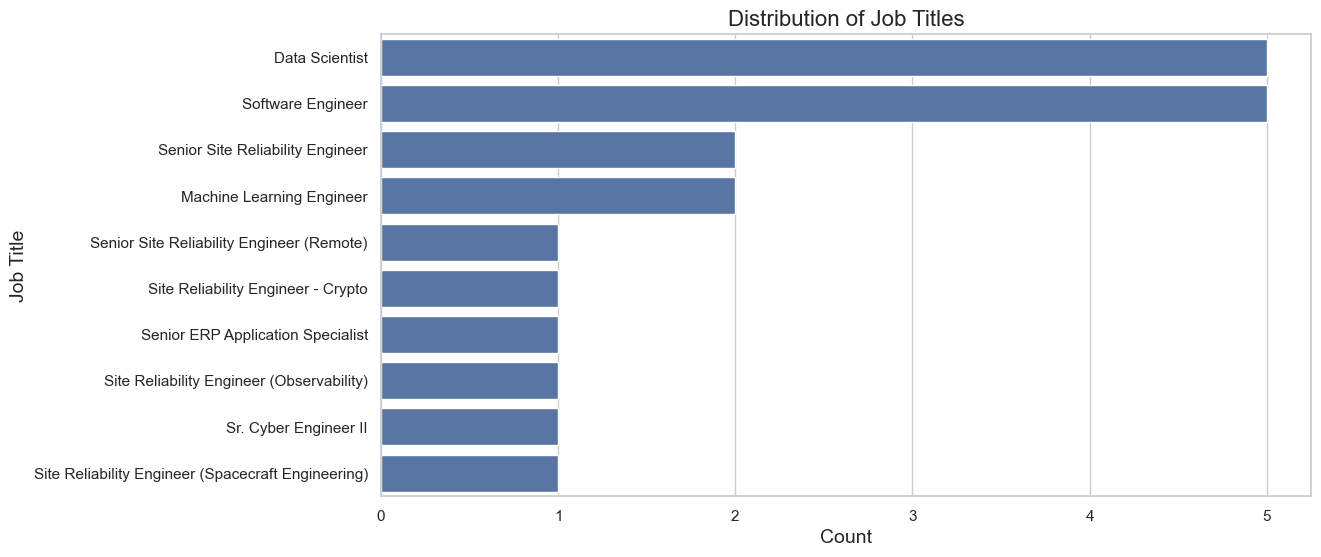

In [285]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Create a countplot for Job_title
sns.countplot(data=df_job_descriptions_20, y='Job_title', order=df_job_descriptions_20['Job_title'].value_counts().index)

# Add titles and labels
plt.title('Distribution of Job Titles', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Job Title', fontsize=14)

# Display the plot
plt.show()

#### 5.1.1 Very Good Fit Resumes

In [298]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a very good fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is good in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit_final_2_test = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit_final_2_test

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,11,Candidate_1_good_1,**Resume: Sophia Richards** \n[Your Address] ...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,Candidate_1_good_2,"**Johnathan C. Miller** \n123 Data Lane, City...",2
2,1,Data Scientist,If you’re passionate about building a better f...,13,Candidate_1_good_3,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",3
3,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,21,Candidate_2_good_1,**Johnathan Smith** \n[Your Address] \n[City...,1
4,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,22,Candidate_2_good_2,**Resume**\n\n**Johnathan Smith** \n1234 Clou...,2
5,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,23,Candidate_2_good_3,"**John Doe** \n[Your Address] \n[City, State...",3
6,3,Software Engineer,"Functions as technical leader for multiple, co...",31,Candidate_3_good_1,**Johnathan R. Smith** \n123 Tech Lane \nWel...,1
7,3,Software Engineer,"Functions as technical leader for multiple, co...",32,Candidate_3_good_2,"**Johnathan R. Blake** \nWellesley, MA 02481 ...",2
8,3,Software Engineer,"Functions as technical leader for multiple, co...",33,Candidate_3_good_3,**Johnathan Smith** \n[LinkedIn Profile] | [E...,3
9,4,Data Scientist,Summary Imagine what you could do here. At App...,41,Candidate_4_good_1,**Jane Doe** \n123 Data Lane \nSan Francisco...,1


#### 5.1.2 Moderate Fit Resumes

In [299]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with poor fit
    for rank in range(4, 7):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a moderate fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is moderate in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit_final_2_test = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit_final_2_test

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,14,Candidate_1_poor_4,**Resume**\n\n**Alice Johnson** \n123 Innovat...,4
1,1,Data Scientist,If you’re passionate about building a better f...,15,Candidate_1_poor_5,**Johnathan Miller** \n123 Innovation Way \n...,5
2,1,Data Scientist,If you’re passionate about building a better f...,16,Candidate_1_poor_6,**Alexandra Thompson** \n123 Innovation Drive...,6
3,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,24,Candidate_2_poor_4,"**John Doe** \n123 Main Street \nCityville, ...",4
4,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,25,Candidate_2_poor_5,**Resume**\n\n**Jordan Taylor** \n[Address] ...,5
5,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,26,Candidate_2_poor_6,**Johnathan Miller** \n[Your Address] \n[Cit...,6
6,3,Software Engineer,"Functions as technical leader for multiple, co...",34,Candidate_3_poor_4,**Johnathan R. Smith** \n123 Tech Drive \nWe...,4
7,3,Software Engineer,"Functions as technical leader for multiple, co...",35,Candidate_3_poor_5,**John D. Smith** \n123 Tech Lane \nWellesle...,5
8,3,Software Engineer,"Functions as technical leader for multiple, co...",36,Candidate_3_poor_6,**John D. Smith** \n123 Tech Lane \nWellesle...,6
9,4,Data Scientist,Summary Imagine what you could do here. At App...,44,Candidate_4_poor_4,**Resume**\n\n**Jessica Taylor** \n[Email: je...,4


#### 5.1.3 Merging the Dataframes

In [300]:
# Merge the dataframes, ensuring all rows are included
merged_df_2_test = pd.concat([df_resumes_good_fit_final_2_test, df_resumes_poor_fit_final_2_test], ignore_index=True)

# Convert CV ID to integer for accurate sorting
merged_df_2_test['CV ID'] = merged_df_2_test['CV ID'].astype(int)

# Sort the merged dataframe by CV ID
df_synth_data_2_test = merged_df_2_test.sort_values(by='CV ID')

# Reset the index after sorting
df_synth_data_2_test.reset_index(drop=True, inplace=True)

# Display the sorted dataframe
df_synth_data_2_test

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,11,Candidate_1_good_1,**Resume: Sophia Richards** \n[Your Address] ...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,Candidate_1_good_2,"**Johnathan C. Miller** \n123 Data Lane, City...",2
2,1,Data Scientist,If you’re passionate about building a better f...,13,Candidate_1_good_3,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",3
3,1,Data Scientist,If you’re passionate about building a better f...,14,Candidate_1_poor_4,**Resume**\n\n**Alice Johnson** \n123 Innovat...,4
4,1,Data Scientist,If you’re passionate about building a better f...,15,Candidate_1_poor_5,**Johnathan Miller** \n123 Innovation Way \n...,5
...,...,...,...,...,...,...,...
115,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,Candidate_20_good_2,"**John D. Anderson** \n[Los Angeles, CA] \n[...",2
116,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,Candidate_20_good_3,"**Johnathan Reyes** \n1234 Galactic Way, Hawt...",3
117,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,Candidate_20_poor_4,**John Doe** \n123 Stellar Drive \nHawthorne...,4
118,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,205,Candidate_20_poor_5,**John R. Thompson** \n1234 Tech Lane \nHawt...,5


In [301]:
# Rename and drop columns
df_synth_data_2_test = df_synth_data_2_test.rename(
    columns={
        "Job Description ID": "JD_ID",
        "Job Title": "JD_title",
        "Job description text": "JD_text",
        "CV ID": "CV_ID",
        "CV": "CV_text",
        "Rank": "label"
    }
)

# Drop the 'CV name' column
df_synth_data_2_test = df_synth_data_2_test.drop(columns=["CV name"])

# Display the updated dataframe
df_synth_data_2_test.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",2
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",3
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Alice Johnson** \n123 Innovat...,4
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Johnathan Miller** \n123 Innovation Way \n...,5


In [302]:
# Replace values in the 'Label' column
df_synth_data_2_test['label'] = df_synth_data_2_test['label'].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0})

# Display the updated dataframe
df_synth_data_2_test.head(10)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",1
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",1
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Alice Johnson** \n123 Innovat...,0
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Johnathan Miller** \n123 Innovation Way \n...,0
5,1,Data Scientist,If you’re passionate about building a better f...,16,**Alexandra Thompson** \n123 Innovation Drive...,0
6,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,21,**Johnathan Smith** \n[Your Address] \n[City...,1
7,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,22,**Resume**\n\n**Johnathan Smith** \n1234 Clou...,1
8,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,23,"**John Doe** \n[Your Address] \n[City, State...",1
9,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,24,"**John Doe** \n123 Main Street \nCityville, ...",0


In [303]:
df_synth_data_2_test["label"].value_counts()

label
1    60
0    60
Name: count, dtype: int64

In [304]:
df_synth_data_2_test.to_csv("/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_2_test.csv", index=False)

### 5.2 Full JD Dataframe with 100 rows

#### Creating the df_job_descriptions_100 from df_synth_data (no saved csv)

In [1]:
import pandas as pd

# Define the path to the CSV file
file_path = "synthetic_data_csv/df_synth_data.csv"

# Load the CSV file into a DataFrame
df_synth_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm successful import
df_synth_data.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0


In [7]:
# Create a new DataFrame with unique job descriptions
df_job_descriptions_100 = df_synth_data[['JD_ID', 'JD_title', 'JD_text']].drop_duplicates(subset=['JD_ID'])

# Reset the index for the resulting DataFrame
df_job_descriptions_100 = df_job_descriptions_100.reset_index(drop=True)

# Display the first few rows of the resulting DataFrame
df_job_descriptions_100.head()

,JD_ID,JD_title,JD_text
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...
1,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...
2,3,Site Reliability Engineer,"In Microsoft Health Next, our team is transfor..."
3,4,Sr Site Reliability Engineer,Tesla Cloud Engineering group is looking for a...
4,5,Machine Learning Engineer,Tinder connects people. With tens of millions ...


In [8]:
# Rename columns
df_job_descriptions_100 = df_job_descriptions_100.rename(columns={
    'JD_ID': 'Job_ID',
    'JD_title': 'Job_title',
    'JD_text': 'Job_description'
})

# Display the updated DataFrame
df_job_descriptions_100.head()

,Job_ID,Job_title,Job_description
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...
1,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...
2,3,Site Reliability Engineer,"In Microsoft Health Next, our team is transfor..."
3,4,Sr Site Reliability Engineer,Tesla Cloud Engineering group is looking for a...
4,5,Machine Learning Engineer,Tinder connects people. With tens of millions ...


#### 5.2.1 Very good fit resumes

In [12]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_100.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a very good fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is good in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit_final_2_100 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit_final_2_100

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,Candidate_1_good_1,**Resume**\n\n**Jane Smith** \n123 Cloud Lane...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,Candidate_1_good_2,**Jane Doe** \n123 Tech Lane \nSan Francisco...,2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,Candidate_1_good_3,"**John Doe** \n123 Cloud St. \nSunnyvale, CA...",3
3,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,Candidate_2_good_1,"**John Smith** \n[Your Address] \n[City, Sta...",1
4,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,Candidate_2_good_2,**John D. Smith** \n[Email: johnd@samplemail....,2
...,...,...,...,...,...,...,...
295,99,Software Engineer,SeatGeek is building the future of live events...,992,Candidate_99_good_2,**Alex Johnson** \n123 Main Street \nBrookly...,2
296,99,Software Engineer,SeatGeek is building the future of live events...,993,Candidate_99_good_3,**Johnathan Smith** \n1234 Elm Street \nSan ...,3
297,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1001,Candidate_100_good_1,**Resume of Jordan Taylor**\n\n**Contact Infor...,1
298,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,Candidate_100_good_2,**Name:** Jordan Smith \n**Address:** 456 Net...,2


#### 5.2.2 Moderate Fit Resumes

In [13]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_100.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with poor fit
    for rank in range(4, 7):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a moderate fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is moderate in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit_final_2_100 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit_final_2_100

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,Candidate_1_poor_4,**Resume**\n\n**Johnathan A. Smith** \n123 Te...,4
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,Candidate_1_poor_5,"**John M. Anderson** \nSan Francisco, CA \nj...",5
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,Candidate_1_poor_6,"**John D. Smith** \n1234 Tech Lane, San Franc...",6
3,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,Candidate_2_poor_4,**Resume**\n\n**John D. Carter** \n[Your Addr...,4
4,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,Candidate_2_poor_5,**John D. Smith** \n[john.smith@email.com](ma...,5
...,...,...,...,...,...,...,...
295,99,Software Engineer,SeatGeek is building the future of live events...,995,Candidate_99_poor_5,"**Jane Smith** \n[Your Address] \n[City, Sta...",5
296,99,Software Engineer,SeatGeek is building the future of live events...,996,Candidate_99_poor_6,**Resume**\n\n**Johnathan Miller** \nNew York...,6
297,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,Candidate_100_poor_4,"**John Doe**\n\n[Your Address] \n[City, State...",4
298,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,Candidate_100_poor_5,**John D. Smith** \n1234 Technology Lane \nS...,5


#### 5.2.3 Merging the Dataframes

In [14]:
# Merge the dataframes, ensuring all rows are included
merged_df_2_100 = pd.concat([df_resumes_good_fit_final_2_100, df_resumes_poor_fit_final_2_100], ignore_index=True)

# Convert CV ID to integer for accurate sorting
merged_df_2_100['CV ID'] = merged_df_2_100['CV ID'].astype(int)

# Sort the merged dataframe by CV ID
df_synth_data_2_100 = merged_df_2_100.sort_values(by='CV ID')

# Reset the index after sorting
df_synth_data_2_100.reset_index(drop=True, inplace=True)

# Display the sorted dataframe
df_synth_data_2_100.head(3)

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,Candidate_1_good_1,**Resume**\n\n**Jane Smith** \n123 Cloud Lane...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,Candidate_1_good_2,**Jane Doe** \n123 Tech Lane \nSan Francisco...,2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,Candidate_1_good_3,"**John Doe** \n123 Cloud St. \nSunnyvale, CA...",3


In [16]:
# Rename and drop columns
df_synth_data_2_100 = df_synth_data_2_100.rename(
    columns={
        "Job Description ID": "JD_ID",
        "Job Title": "JD_title",
        "Job description text": "JD_text",
        "CV ID": "CV_ID",
        "CV": "CV_text",
        "Rank": "label"
    }
)

# Drop the 'CV name' column
df_synth_data_2_100 = df_synth_data_2_100.drop(columns=["CV name"])

# Display the updated dataframe
df_synth_data_2_100.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**Resume**\n\n**Jane Smith** \n123 Cloud Lane...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**Jane Doe** \n123 Tech Lane \nSan Francisco...,2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,"**John Doe** \n123 Cloud St. \nSunnyvale, CA...",3
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Johnathan A. Smith** \n123 Te...,4
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,"**John M. Anderson** \nSan Francisco, CA \nj...",5


In [17]:
# Replace values in the 'Label' column
df_synth_data_2_100['label'] = df_synth_data_2_100['label'].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0})

# Display the updated dataframe
df_synth_data_2_100.head(8)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**Resume**\n\n**Jane Smith** \n123 Cloud Lane...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**Jane Doe** \n123 Tech Lane \nSan Francisco...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,"**John Doe** \n123 Cloud St. \nSunnyvale, CA...",1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Johnathan A. Smith** \n123 Te...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,"**John M. Anderson** \nSan Francisco, CA \nj...",0
5,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,"**John D. Smith** \n1234 Tech Lane, San Franc...",0
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John Smith** \n[Your Address] \n[City, Sta...",1
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,**John D. Smith** \n[Email: johnd@samplemail....,1


In [19]:
df_synth_data_2_100["label"].value_counts()

label
1    300
0    300
Name: count, dtype: int64

In [20]:
df_synth_data_2_100.to_csv("/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_2_100.csv", index=False)

#### 5.2.4 Random Subset with 20 JDs df_synth_data_2_20

In [21]:
# Subset with 20

# Randomly select 20 unique JD_IDs
random_jds = df_synth_data_2_100['JD_ID'].drop_duplicates().sample(n=20, random_state=42)

# Filter the dataframe to include only the selected JD_IDs
df_synth_data_2_20_v2 = df_synth_data_2_100[df_synth_data_2_100['JD_ID'].isin(random_jds)].reset_index(drop=True)

# Display the resulting subset
df_synth_data_2_20_v2

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**Resume**\n\n**Jane Smith** \n123 Cloud Lane...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**Jane Doe** \n123 Tech Lane \nSan Francisco...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,"**John Doe** \n123 Cloud St. \nSunnyvale, CA...",1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Johnathan A. Smith** \n123 Te...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,"**John M. Anderson** \nSan Francisco, CA \nj...",0
...,...,...,...,...,...,...
115,91,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,912,**Johnathan R. Smith** \n123 Cyber Lane \nDu...,1
116,91,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,913,"**John D. Mitchell** \nDulles, VA 20166 \n(5...",1
117,91,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,914,**John Smith** \n123 Cyber Lane \nSpringfiel...,0
118,91,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,915,**Johnathan Lee** \n123 Cyber Lane \nFairfax...,0


In [25]:
# Adjust JD_IDs to range from 1 to 20
jd_id_mapping = {old_id: new_id for new_id, old_id in enumerate(df_synth_data_2_20_v2['JD_ID'].unique(), start=1)}
df_synth_data_2_20_v2['JD_ID'] = df_synth_data_2_20_v2['JD_ID'].map(jd_id_mapping)

# Adjust CV_IDs based on the new JD_ID
df_synth_data_2_20_v2['CV_ID'] = (
    df_synth_data_2_20_v2.groupby('JD_ID').cumcount() + 1  # Generate CV_IDs from 1 to 6 for each JD_ID
).astype(str)  # Ensure numbers are strings
df_synth_data_2_20_v2['CV_ID'] = df_synth_data_2_20_v2['JD_ID'].astype(str) + df_synth_data_2_20_v2['CV_ID']

# Reset the index after the adjustments
df_synth_data_2_20_v2 = df_synth_data_2_20_v2.reset_index(drop=True)

# Display the resulting dataframe
df_synth_data_2_20_v2

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**Resume**\n\n**Jane Smith** \n123 Cloud Lane...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**Jane Doe** \n123 Tech Lane \nSan Francisco...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,"**John Doe** \n123 Cloud St. \nSunnyvale, CA...",1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Johnathan A. Smith** \n123 Te...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,"**John M. Anderson** \nSan Francisco, CA \nj...",0
...,...,...,...,...,...,...
115,20,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,202,**Johnathan R. Smith** \n123 Cyber Lane \nDu...,1
116,20,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,203,"**John D. Mitchell** \nDulles, VA 20166 \n(5...",1
117,20,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,204,**John Smith** \n123 Cyber Lane \nSpringfiel...,0
118,20,Sr. Cyber Engineer II,Raytheon IIS is looking for a highly motivated...,205,**Johnathan Lee** \n123 Cyber Lane \nFairfax...,0


In [27]:
# Output unique JD_IDs
print("Unique JD_IDs:")
print(df_synth_data_2_20_v2['JD_ID'].unique())

# Output unique CV_IDs
print("\nUnique CV_IDs:")
print(df_synth_data_2_20_v2['CV_ID'].unique())

Unique JD_IDs:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Unique CV_IDs:
['11' '12' '13' '14' '15' '16' '21' '22' '23' '24' '25' '26' '31' '32'
 '33' '34' '35' '36' '41' '42' '43' '44' '45' '46' '51' '52' '53' '54'
 '55' '56' '61' '62' '63' '64' '65' '66' '71' '72' '73' '74' '75' '76'
 '81' '82' '83' '84' '85' '86' '91' '92' '93' '94' '95' '96' '101' '102'
 '103' '104' '105' '106' '111' '112' '113' '114' '115' '116' '121' '122'
 '123' '124' '125' '126' '131' '132' '133' '134' '135' '136' '141' '142'
 '143' '144' '145' '146' '151' '152' '153' '154' '155' '156' '161' '162'
 '163' '164' '165' '166' '171' '172' '173' '174' '175' '176' '181' '182'
 '183' '184' '185' '186' '191' '192' '193' '194' '195' '196' '201' '202'
 '203' '204' '205' '206']


In [28]:
df_synth_data_2_20_v2.to_csv("/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_2_20.csv", index=False)

## 6 Third Attempt: Synthetic Data Generation

**Specs:**
- 20 JDs a 6 CVs
- 1 Promt generating 3 resumes: No rank, ALL **"almost perfect fit"**
- 1 Promt generating 3 resumes: No rank, ALL **"slightly bad to moderate fit"**

## 7 Fourth Attempt: Synthetic Data Generation (Same as 6 but 100 instead of 20 JDs)

**Specs:**
- **100 JDs** a 6 CVs
- 1 Promt generating 3 resumes: No rank, ALL **"almost perfect fit"**
- 1 Promt generating 3 resumes: No rank, ALL **"slightly bad to moderate fit"**

### 7.1 Almost perfect fit resumes

In [318]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_100.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with good fit
    for rank in range(1, 4):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having an almost perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is almost perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_good_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit_final_4_100 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit_final_4_100

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,Candidate_1_good_1,**John D. Smith** \n123 Cloud Lane \nPleasan...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,Candidate_1_good_2,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,Candidate_1_good_3,**Resume**\n\n**John Doe** \n[Your Address] ...,3
3,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,Candidate_2_good_1,"**John Doe** \n[Your Address] \n[City, State...",1
4,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,Candidate_2_good_2,**Resume**\n\n**John Doe** \n[Your Address] ...,2
...,...,...,...,...,...,...,...
295,99,Software Engineer,SeatGeek is building the future of live events...,992,Candidate_99_good_2,"**Jane Doe** \n[Your Address] \n[City, State...",2
296,99,Software Engineer,SeatGeek is building the future of live events...,993,Candidate_99_good_3,"**John Doe** \n[Your Address] \n[City, State...",3
297,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1001,Candidate_100_good_1,"**John Doe** \n1234 Tech Lane \nAustin, TX 7...",1
298,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,Candidate_100_good_2,"**John Doe** \n123 Tech Lane \nAustin, TX 78...",2


### 7.2 Slightly bad to moderate Fit Resumes

In [319]:
# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_100.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # Generate 3 resumes with poor fit
    for rank in range(4, 7):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a slightly bad to moderate fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is slightly bad to moderate in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text': job_description,
            'CV ID': f"{job_id}{rank}",
            'CV name': f"Candidate_{job_id}_poor_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes_poor_fit_final_4_100 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_poor_fit_final_4_100

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,Candidate_1_poor_4,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,4
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,Candidate_1_poor_5,**John Smith** \n[Email: john.smith@email.com...,5
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,Candidate_1_poor_6,**John W. Smith** \n123 Tech Avenue \nSan Fr...,6
3,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,Candidate_2_poor_4,"**John D. Smith** \n[Your Address] \n[City, ...",4
4,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,Candidate_2_poor_5,**Resume**\n\n**John Doe** \n1234 Elm Street ...,5
...,...,...,...,...,...,...,...
295,99,Software Engineer,SeatGeek is building the future of live events...,995,Candidate_99_poor_5,"**Jane Doe** \n[Your Address] \n[City, State...",5
296,99,Software Engineer,SeatGeek is building the future of live events...,996,Candidate_99_poor_6,**Resume**\n\n**John Smith** \n123 Tech Lane ...,6
297,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,Candidate_100_poor_4,"**John Doe** \n123 Tech Lane, Silicon Valley,...",4
298,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,Candidate_100_poor_5,**John Doe** \n123 Tech Lane \nSan Francisco...,5


### 7.3 Merging the Dataframes and saving the result

In [320]:
# Merge the dataframes, ensuring all rows are included
merged_df_4_100 = pd.concat([df_resumes_good_fit_final_4_100, df_resumes_poor_fit_final_4_100], ignore_index=True)

# Convert CV ID to integer for accurate sorting
merged_df_4_100['CV ID'] = merged_df_4_100['CV ID'].astype(int)

# Sort the merged dataframe by CV ID
df_synth_data_4_100 = merged_df_4_100.sort_values(by='CV ID')

# Reset the index after sorting
df_synth_data_4_100.reset_index(drop=True, inplace=True)

# Display the sorted dataframe
df_synth_data_4_100

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,Candidate_1_good_1,**John D. Smith** \n123 Cloud Lane \nPleasan...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,Candidate_1_good_2,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,Candidate_1_good_3,**Resume**\n\n**John Doe** \n[Your Address] ...,3
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,Candidate_1_poor_4,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,4
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,Candidate_1_poor_5,**John Smith** \n[Email: john.smith@email.com...,5
...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,Candidate_100_good_2,"**John Doe** \n123 Tech Lane \nAustin, TX 78...",2
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,Candidate_100_good_3,"**John Doe** \n1234 Tech Lane \nAustin, TX 7...",3
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,Candidate_100_poor_4,"**John Doe** \n123 Tech Lane, Silicon Valley,...",4
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,Candidate_100_poor_5,**John Doe** \n123 Tech Lane \nSan Francisco...,5


In [321]:
# Rename and drop columns
df_synth_data_4_100 = df_synth_data_4_100.rename(
    columns={
        "Job Description ID": "JD_ID",
        "Job Title": "JD_title",
        "Job description text": "JD_text",
        "CV ID": "CV_ID",
        "CV": "CV_text",
        "Rank": "label"
    }
)

# Drop the 'CV name' column
df_synth_data_4_100 = df_synth_data_4_100.drop(columns=["CV name"])

# Display the updated dataframe
df_synth_data_4_100.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",2
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,3
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,4
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n[Email: john.smith@email.com...,5


In [322]:
# Replace values in the 'Label' column
df_synth_data_4_100['label'] = df_synth_data_4_100['label'].replace({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0})

# Display the updated dataframe
df_synth_data_4_100.head(10)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n[Email: john.smith@email.com...,0
5,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,**John W. Smith** \n123 Tech Avenue \nSan Fr...,0
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John Doe** \n[Your Address] \n[City, State...",1
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,**Resume**\n\n**John Doe** \n[Your Address] ...,1
8,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,23,**John Smith** \n1234 Tech Lane \nSan Franci...,1
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,"**John D. Smith** \n[Your Address] \n[City, ...",0


In [323]:
df_synth_data_4_100["label"].value_counts()

label
1    300
0    300
Name: count, dtype: int64

In [324]:
df_synth_data_4_100.to_csv("/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_4_100.csv", index=False)

## 8 New Approach - Ranking (with 5 seperate Promts)

### 8.1 5 different Promts for the different levels of fit

#### 8.1.1 Perfect fit

In [329]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # System message providing context
    system_message = {
        "role": "system",
        "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a perfect fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
    }
    
    # User message with specific instructions
    user_message = {
        "role": "user",
        "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is perfect in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
    }
    
    # Invoke the client's chat completion method
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            system_message,
            user_message
        ]
    )
    
    # Extract the generated resume
    resume_text = completion.choices[0].message.content.strip()
    
    # Append the resume and associated data to the list
    generated_resumes_list.append({
        'Job Description ID': job_id,
        'Job Title': job_title,
        'Job description text': job_description,
        'CV ID': f"{job_id}1",  # Only one resume, so fixed ID suffix
        'CV name': f"Candidate_{job_id}_good",  # Simplified name
        'CV': resume_text,
        'Rank': 1  # Fixed rank
    })

# Create a DataFrame from the list of generated resumes
df_resumes_perfect_fit_final_5_20 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_perfect_fit_final_5_20

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,11,Candidate_1_good,**Michael J. Thompson** \n[Your Address] \n[...,1
1,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,21,Candidate_2_good,"**Resume**\n\n**John Doe** \nLos Angeles, CA ...",1
2,3,Software Engineer,"Functions as technical leader for multiple, co...",31,Candidate_3_good,**Johnathan Smith** \n123 Tech Lane \nWelles...,1
3,4,Data Scientist,Summary Imagine what you could do here. At App...,41,Candidate_4_good,**John Doe** \n123 Data Lane \nSan Francisco...,1
4,5,Senior Site Reliability Engineer,Primary Responsibilities Develop automation to...,51,Candidate_5_good,"**John D. Smith** \n[City, State] | [Phone Nu...",1
5,6,Software Engineer,Nuix creates innovative software that empowers...,61,Candidate_6_good,**Alex Johnson** \n123 Maple Lane \nSpringfi...,1
6,7,Site Reliability Engineer - Crypto,Coinbase has built the world's leading complia...,71,Candidate_7_good,"**David Thompson** \n[Your Address] \n[City,...",1
7,8,Senior ERP Application Specialist,"As a Senior ERP Application Specialist, you wi...",81,Candidate_8_good,"**John Smith** \n123 ERP Way \nTech City, TX...",1
8,9,Data Scientist,"At Shipt, we are transforming the grocery shop...",91,Candidate_9_good,**Jacob Reynolds** \n[LinkedIn Profile] | [Em...,1
9,10,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,101,Candidate_10_good,"**John Doe** \n1234 Technology Way, \nMounta...",1


#### 8.1.2 Good fit

In [330]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # System message providing context
    system_message = {
        "role": "system",
        "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a good fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
    }
    
    # User message with specific instructions
    user_message = {
        "role": "user",
        "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is good in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
    }
    
    # Invoke the client's chat completion method
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            system_message,
            user_message
        ]
    )
    
    # Extract the generated resume
    resume_text = completion.choices[0].message.content.strip()
    
    # Append the resume and associated data to the list
    generated_resumes_list.append({
        'Job Description ID': job_id,
        'Job Title': job_title,
        'Job description text': job_description,
        'CV ID': f"{job_id}2",  # Only one resume, so fixed ID suffix
        'CV name': f"Candidate_{job_id}_good",  # Simplified name
        'CV': resume_text,
        'Rank': 2  # Fixed rank
    })

# Create a DataFrame from the list of generated resumes
df_resumes_good_fit_final_5_20 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_good_fit_final_5_20

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,12,Candidate_1_good,"**John Smith** \n[Your Address] \n[City, Sta...",2
1,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,22,Candidate_2_good,**Resume**\n\n**John Smith** \n123 Tech Lane ...,2
2,3,Software Engineer,"Functions as technical leader for multiple, co...",32,Candidate_3_good,**John D. Anderson** \n123 Tech Lane \nWelle...,2
3,4,Data Scientist,Summary Imagine what you could do here. At App...,42,Candidate_4_good,"**John Doe**\n\n[123 Main St, Cupertino, CA 95...",2
4,5,Senior Site Reliability Engineer,Primary Responsibilities Develop automation to...,52,Candidate_5_good,**Alex Johnson** \n123 Tech Avenue \nSan Fra...,2
5,6,Software Engineer,Nuix creates innovative software that empowers...,62,Candidate_6_good,**Resume**\n\n**John Smith** \n123 Tech Lane ...,2
6,7,Site Reliability Engineer - Crypto,Coinbase has built the world's leading complia...,72,Candidate_7_good,**Resume**\n\n**John Smith** \n[Your Address]...,2
7,8,Senior ERP Application Specialist,"As a Senior ERP Application Specialist, you wi...",82,Candidate_8_good,"**Laura Jensen** \n123 Main Street \nNewark,...",2
8,9,Data Scientist,"At Shipt, we are transforming the grocery shop...",92,Candidate_9_good,**John A. Data** \n123 Analytics Lane \nSan ...,2
9,10,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,102,Candidate_10_good,**Resume**\n\n**John Doe** \n[LinkedIn URL] |...,2


#### 8.1.3 Moderate fit

In [331]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # System message providing context
    system_message = {
        "role": "system",
        "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a moderate fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
    }
    
    # User message with specific instructions
    user_message = {
        "role": "user",
        "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is moderate in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
    }
    
    # Invoke the client's chat completion method
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            system_message,
            user_message
        ]
    )
    
    # Extract the generated resume
    resume_text = completion.choices[0].message.content.strip()
    
    # Append the resume and associated data to the list
    generated_resumes_list.append({
        'Job Description ID': job_id,
        'Job Title': job_title,
        'Job description text': job_description,
        'CV ID': f"{job_id}3",  # Only one resume, so fixed ID suffix
        'CV name': f"Candidate_{job_id}_good",  # Simplified name
        'CV': resume_text,
        'Rank': 3  # Fixed rank
    })

# Create a DataFrame from the list of generated resumes
df_resumes_moderate_fit_final_5_20 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_moderate_fit_final_5_20

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,13,Candidate_1_good,"**Resume**\n\n**John Doe** \n[City, State] \...",3
1,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,23,Candidate_2_good,"**John Doe** \n[Your Address] \n[City, State...",3
2,3,Software Engineer,"Functions as technical leader for multiple, co...",33,Candidate_3_good,"**John Doe** \n123 Tech Lane \nWellesley, MA...",3
3,4,Data Scientist,Summary Imagine what you could do here. At App...,43,Candidate_4_good,**John D. Richardson** \n123 Data Lane \nSan...,3
4,5,Senior Site Reliability Engineer,Primary Responsibilities Develop automation to...,53,Candidate_5_good,**John D. Cashman**\n\n[Your Address] \n[City...,3
5,6,Software Engineer,Nuix creates innovative software that empowers...,63,Candidate_6_good,**Johnathan Smith** \n123 Tech Lane \nSan Fr...,3
6,7,Site Reliability Engineer - Crypto,Coinbase has built the world's leading complia...,73,Candidate_7_good,**Resume**\n\n**Jordan Smith** \n[Phone Numbe...,3
7,8,Senior ERP Application Specialist,"As a Senior ERP Application Specialist, you wi...",83,Candidate_8_good,"**James L. Thompson** \n1234 Elm Street, Spri...",3
8,9,Data Scientist,"At Shipt, we are transforming the grocery shop...",93,Candidate_9_good,**Resume**\n\n**Johnathan Smith** \n123 Data ...,3
9,10,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,103,Candidate_10_good,"**John Miller** \nSan Francisco, CA \njohn.m...",3


#### 8.1.4 Bad fit

In [332]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # System message providing context
    system_message = {
        "role": "system",
        "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having a bad fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
    }
    
    # User message with specific instructions
    user_message = {
        "role": "user",
        "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the skill alignment between the resume and the job description is bad in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
    }
    
    # Invoke the client's chat completion method
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            system_message,
            user_message
        ]
    )
    
    # Extract the generated resume
    resume_text = completion.choices[0].message.content.strip()
    
    # Append the resume and associated data to the list
    generated_resumes_list.append({
        'Job Description ID': job_id,
        'Job Title': job_title,
        'Job description text': job_description,
        'CV ID': f"{job_id}4",  # Only one resume, so fixed ID suffix
        'CV name': f"Candidate_{job_id}_good",  # Simplified name
        'CV': resume_text,
        'Rank': 4  # Fixed rank
    })

# Create a DataFrame from the list of generated resumes
df_resumes_bad_fit_final_5_20 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_bad_fit_final_5_20

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,14,Candidate_1_good,**Resume**\n\n**Jessica Taylor** \nEmail: jes...,4
1,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,24,Candidate_2_good,**Resume**\n\n**John Doe** \n123 Maple Street...,4
2,3,Software Engineer,"Functions as technical leader for multiple, co...",34,Candidate_3_good,**Resume:**\n\n**Johnathan Smith** \nEmail: j...,4
3,4,Data Scientist,Summary Imagine what you could do here. At App...,44,Candidate_4_good,**Resume**\n\n**John Smith** \n123 Tech Lane ...,4
4,5,Senior Site Reliability Engineer,Primary Responsibilities Develop automation to...,54,Candidate_5_good,**Resume: Alex Johnson** \n[Email: alex.johns...,4
5,6,Software Engineer,Nuix creates innovative software that empowers...,64,Candidate_6_good,"**John Doe** \n1234 Elm Street \nNewtown, St...",4
6,7,Site Reliability Engineer - Crypto,Coinbase has built the world's leading complia...,74,Candidate_7_good,**Resume**\n\n**Johnathan Greenfield** \n123 ...,4
7,8,Senior ERP Application Specialist,"As a Senior ERP Application Specialist, you wi...",84,Candidate_8_good,"**John Doe** \n123 Elm Street \nSpringfield,...",4
8,9,Data Scientist,"At Shipt, we are transforming the grocery shop...",94,Candidate_9_good,**Resume**\n\n**Name:** Martin Jenkins \n**Ad...,4
9,10,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,104,Candidate_10_good,**Resume**\n\n**Johnathan Miller** \n1234 Elm...,4


#### 8.1.5 No fit

In [333]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_job_descriptions_20.iterrows():
    job_id = row['Job_ID']
    job_title = row['Job_title']
    job_description = row['Job_description']
    
    # System message providing context
    system_message = {
        "role": "system",
        "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to create clearly differentiable resumes all having no fit with the provided job description only based on skill alignment.
The fit **must not depend** on any other factor except of the skills mentioned in the resume and the job description.
Do not include any note or explanation of how you generate the resumes.
"""
    }
    
    # User message with specific instructions
    user_message = {
        "role": "user",
        "content": f"""
Generate a resume for an unique candidate applying for the following tech job. Make sure the resume and the job description have no skill alignment in terms of exact skill matches and related skills.

**Job Description:**

{job_description}
"""
    }
    
    # Invoke the client's chat completion method
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            system_message,
            user_message
        ]
    )
    
    # Extract the generated resume
    resume_text = completion.choices[0].message.content.strip()
    
    # Append the resume and associated data to the list
    generated_resumes_list.append({
        'Job Description ID': job_id,
        'Job Title': job_title,
        'Job description text': job_description,
        'CV ID': f"{job_id}5",  # Only one resume, so fixed ID suffix
        'CV name': f"Candidate_{job_id}_good",  # Simplified name
        'CV': resume_text,
        'Rank': 5  # Fixed rank
    })

# Create a DataFrame from the list of generated resumes
df_resumes_no_fit_final_5_20 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes_no_fit_final_5_20

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,15,Candidate_1_good,**Resume**\n\n**Name:** Jordan Bennett \n**Ad...,5
1,2,Senior Site Reliability Engineer (Remote),Work for a great company! This Jobot Job is ho...,25,Candidate_2_good,**Johnathan R. Smith** \n123 Oceanview Avenue...,5
2,3,Software Engineer,"Functions as technical leader for multiple, co...",35,Candidate_3_good,**Jane Doe** \n123 Tech Lane \nInnovation Ci...,5
3,4,Data Scientist,Summary Imagine what you could do here. At App...,45,Candidate_4_good,**Resume**\n\n**Johnathan Grey** \n123 Tech L...,5
4,5,Senior Site Reliability Engineer,Primary Responsibilities Develop automation to...,55,Candidate_5_good,**Johnathan Swift** \n123 Innovation Road \n...,5
5,6,Software Engineer,Nuix creates innovative software that empowers...,65,Candidate_6_good,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,5
6,7,Site Reliability Engineer - Crypto,Coinbase has built the world's leading complia...,75,Candidate_7_good,**Jane Doe** \nEmail: janedoe@email.com \nPh...,5
7,8,Senior ERP Application Specialist,"As a Senior ERP Application Specialist, you wi...",85,Candidate_8_good,"**John Anderson** \n123 Tech Ave, San Francis...",5
8,9,Data Scientist,"At Shipt, we are transforming the grocery shop...",95,Candidate_9_good,**Resume for Alex Thompson** \nEmail: alex.th...,5
9,10,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,105,Candidate_10_good,**Johnathan Smith** \n123 Pine Street \nSan ...,5


### 8.2 Merging the dataframes and saving the result

In [340]:
# Merge the five dataframes, ensuring all rows are included
merged_df_5_20 = pd.concat([
    df_resumes_perfect_fit_final_5_20,
    df_resumes_good_fit_final_5_20,
    df_resumes_moderate_fit_final_5_20,
    df_resumes_bad_fit_final_5_20,
    df_resumes_no_fit_final_5_20
], ignore_index=True)

# Convert CV ID to integer for accurate sorting
merged_df_5_20['CV ID'] = merged_df_5_20['CV ID'].astype(int)

# Sort the merged dataframe by CV ID
df_synth_data_5_20 = merged_df_5_20.sort_values(by='CV ID')

# Reset the index after sorting
df_synth_data_5_20.reset_index(drop=True, inplace=True)

# Display the sorted dataframe
df_synth_data_5_20

,Job Description ID,Job Title,Job description text,CV ID,CV name,CV,Rank
0,1,Data Scientist,If you’re passionate about building a better f...,11,Candidate_1_good,**Michael J. Thompson** \n[Your Address] \n[...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,Candidate_1_good,"**John Smith** \n[Your Address] \n[City, Sta...",2
2,1,Data Scientist,If you’re passionate about building a better f...,13,Candidate_1_good,"**Resume**\n\n**John Doe** \n[City, State] \...",3
3,1,Data Scientist,If you’re passionate about building a better f...,14,Candidate_1_good,**Resume**\n\n**Jessica Taylor** \nEmail: jes...,4
4,1,Data Scientist,If you’re passionate about building a better f...,15,Candidate_1_good,**Resume**\n\n**Name:** Jordan Bennett \n**Ad...,5
...,...,...,...,...,...,...,...
95,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,201,Candidate_20_good,"**Samuel Harper** \nLos Angeles, CA | samue...",1
96,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,Candidate_20_good,**John M. Carter** \n123 Stellar Way \nHawth...,2
97,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,Candidate_20_good,**Resume**\n\n**John H. Adams** \nSanta Monic...,3
98,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,Candidate_20_good,"**Alexandra Turner** \n123 Maple St, San Dieg...",4


In [341]:
# Rename and drop columns
df_synth_data_5_20 = df_synth_data_5_20.rename(
    columns={
        "Job Description ID": "JD_ID",
        "Job Title": "JD_title",
        "Job description text": "JD_text",
        "CV ID": "CV_ID",
        "CV": "CV_text",
        "Rank": "label"
    }
)

# Drop the 'CV name' column
df_synth_data_5_20 = df_synth_data_5_20.drop(columns=["CV name"])

# Display the updated dataframe
df_synth_data_5_20.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Michael J. Thompson** \n[Your Address] \n[...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**John Smith** \n[Your Address] \n[City, Sta...",2
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**Resume**\n\n**John Doe** \n[City, State] \...",3
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Jessica Taylor** \nEmail: jes...,4
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Resume**\n\n**Name:** Jordan Bennett \n**Ad...,5


In [342]:
df_synth_data_5_20["label"].value_counts()

label
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64

In [343]:
df_synth_data_5_20.to_csv("/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_5_20.csv", index=False)